<div >
<img src = "figs/ans_banner_1920x200.png" />
</div>

# Propuesta Proyecto Final Grupo 5

Bogotá tiene un sistema educativo robusto. Uno de cada tres habitantes de la ciudad está vinculado al sistema educativo de la ciudad, que reúne casi 2,5 millones de personas de los cuales 1,4 millones son niños, niñas y adolescentes en los niveles preescolar, básica, secundaria y media (académica y técnica). Cerca de 743.000 de ellos son atendidos por el sector oficial y 425.000, por el sector privado. Las localidades con mayor matrícula son Suba, Kennedy y Bosa. La oferta del sector oficial está concentrada en las localidades de Bosa, Kennedy y Ciudad Bolívar, donde se atiende cerca del 25 % de estudiantes de la ciudad (Secretaría Distrital de Educación, 2024). 

Adicionalmente, considerando que Bogotá cuenta con una alta población infantil que representa el 23,6 % de los habitantes, con una marcada desigualdad socioeconómica, se hace evidente la necesidad depd.intervenciones específicas bajo un enfoque territorial, diferencial,pd.interseccional y de género. Sectores con índices significativos de pobreza y extrema pobreza, junto con la diversidad cultural y étnica, requieren enfoques diferenciados y pertinentes para abordar las particularidades de cada comunidad. 

En cuanto a instituciones, Bogotá cuenta con 1.962 colegios, 1.881 jardines, 134 instituciones de educación superior (IES) y 445 de educación para el trabajo y el desarrollo humano (IETDH). De los colegios, el sector oficial cuenta con 406 instituciones (371 de administración directa y 35 de administración contratada), el sector privado cuenta con 1.551 y existen 5 colegios oficiales con régimen especial. En la Ilustración 1   se encuentran georreferenciados los colegios del sector oficial, no oficial y las IES.   

Ilustración 1 – Colegios oficiales, No Oficiales & IES. 

![I1](figs/Ilustracion1.jpg)

Fuente:'SED con base en el DUE & IDECA. 

Al realizar un análisis de oferta y demanda para el sector oficial (en los niveles de preescolar a media), se encuentra que persiste un déficit de cupos en algunas zonas de la ciudad; especialmente UPZ de las localidades de Suba, Kennedy, Bosa, Antonio Nariño. Ciudad Bolívar y Usme. Este déficit de cupos es significativo para el nivel de preescolar en las UPZ El Rincón, Tibabuyes y Patio Bonito.   

Ilustración 2- Déficit/ Superávit del Sector Oficial por Nivel Educativo. 

![I2](figs/Ilustracion2.png)

 

Fuente:'Estudio de Insuficiencia y Limitaciones 2023 (Secretaría de Educación del Distrito, 2022) 

La gestión de la cobertura educativa gira en torno a la modernización del proceso para la asignación eficiente de cupos educativos en Bogotá siendo una prioridad para garantizar que todas y todos los estudiantes tengan acceso a una educación de calidad. Mejorar y optimizar el proceso de asignación de cupos y la reducción de las barreras que limitan el acceso de los niños, niñas, adolescentes y jóvenes al sistema educativo y, de esta manera, promover la igualdad y equidad de oportunidades. 

In [221]:
# data analysis libs
import pandas as pd
import numpy as np
import session_info
import datetime
import pickle
pd.set_option('display.max_columns', None)

# data viz libs
import matplotlib.pyplot as plt
import seaborn as sns

# re
import re


## 1. Análisis descriptivo de datos

### 1.1 Carga de datos

Para este proyecto se cuenta con 3 bases de datos.

* Información de estudiantespd.interesados en la inscripción a un colegio distrital, que llamaremos `inscripciones`.
* Puntajes de pruebas saber 3,5,9,11, que llamaremos `icfes`.
* Datos de capacidad y área por colegios, que llamaremos `capacidad`.

In [4]:
%run aux_creador_dict.py

In [28]:
# Carga de datos de inscripciones
dict_inscripciones = pickle.load(open("dict_inscripciones.p", "rb"))
col_names = [col_name for col_name in dict_inscripciones.keys()]
inscripciones = pd.read_excel('data/9103Z1-Inscripciones2024-DatosGenerales-20240719.xlsx'
                              , sheet_name = "Inscripcion2024")
inscripciones = inscripciones[col_names]
inscripciones = inscripciones.astype(dict_inscripciones)
inscripciones['ASIGNADO_DANE_SEDE'] = inscripciones['ASIGNADO_DANE_SEDE'].astype('str').str.replace('.0', '')
inscripciones['ASIGNADO_DANE_IED'] = inscripciones['ASIGNADO_DANE_IED'].astype('str').str.replace('.0', '')

In [81]:
# Carga de datos ICFES
icfes = pd.read_excel('data/ActualizaSABER_11_2023_Def_Rdsl.xlsx', sheet_name = 'PROMEDIOS_NIVELES_IE')
icfes = icfes[['AÑO', 'CODIGODANE','P_Puntaje_Global','EVALUADOS']]
icfes = icfes.rename(columns={'CODIGODANE':'ASIGNADO_DANE_SEDE','P_Puntaje_Global':'Puntaje ICFES 11', 'EVALUADOS':'Evaluados ICFES 11'})
icfes['ASIGNADO_DANE_SEDE'] = icfes['ASIGNADO_DANE_SEDE'].astype('str').str.replace('.0', '')
icfes = icfes.groupby('ASIGNADO_DANE_SEDE')[['Puntaje ICFES 11', 'Evaluados ICFES 11']].mean().reset_index()
# estandarizamos para que los puntajes estén entre 0 y 100.
icfes['Puntaje ICFES 11'] = icfes['Puntaje ICFES 11']/5

In [30]:
# Carga de datos capacidad instalada
capacidad = pd.read_excel('data/VARIABLES CAPACIDAD INSTALADA mod.xlsx', sheet_name = 'MATRIZ GENERAL')
capacidad = capacidad[['CODIGO DANE ','CAPACIDAD INSTALADA - PREESCOLAR', 'CAPACIDAD INSTALADA - 1-11',
       'CAPACIDAD INSTALADA - Total', 'AULAS  Preescolar', 'AULAS  1-11',
       'ÁREAS - PREESCOLAR', 'ÁREAS   1-11']]
capacidad = capacidad.dropna(subset=['CODIGO DANE '])
capacidad['CODIGO DANE '] = capacidad['CODIGO DANE '].dropna().astype('str').str.replace('.0', '')
capacidad = capacidad.rename(columns={'CODIGO DANE ': 'ASIGNADO_DANE_SEDE'})

In [31]:
# Cupo ofrecidos
cupos = pd.read_excel('data/Base oferta de cupos 2024.xlsx', sheet_name = "Hoja1")
cupos = cupos.rename(columns={'DANE': 'ASIGNADO_DANE_IED', 'GRADO': 'INR_GRADO'})[['ASIGNADO_DANE_IED', 'INR_GRADO', 'CUPOS 2024']]
cupos['ASIGNADO_DANE_IED'] = cupos['ASIGNADO_DANE_IED'].dropna().astype('str').str.replace('.0', '')

In [37]:
# Saber resultados
saber = pd.read_csv('data/Saber 2014-2017 - puntajes.csv')
saber = saber.rename(columns={'DANE': 'ASIGNADO_DANE_IED'})[['ASIGNADO_DANE_IED', 'PuntajeGlobal']]
saber['ASIGNADO_DANE_IED'] = saber['ASIGNADO_DANE_IED'].dropna().astype('str').str.replace('.0', '')

### 1.2 Consolidacion Datos

En esta sección consolidamos los datos en un único dataframe

In [180]:
df = inscripciones.merge(icfes
                        , how= 'left'
                        , on = 'ASIGNADO_DANE_SEDE').merge(capacidad
                                                           , on = 'ASIGNADO_DANE_SEDE'
                                                           , how='left').merge(cupos
                                                                               , on = ['ASIGNADO_DANE_IED', 'INR_GRADO']
                                                                               , how = 'left')
# para los colegios que no cuentan con grado 11 (y que por lo tanto no tienen puntajes de ICFES cruzamos con la base de datos las pruebas saber saber)
aux_col = df[df['Puntaje ICFES 11'].isna()].merge(saber, on = 'ASIGNADO_DANE_IED', how= 'left')['PuntajeGlobal']
df.loc[df['Puntaje ICFES 11'].isna(),'Puntaje ICFES 11'] = aux_col

# eliminamos los datos que no cuentan con información de calidad educativa
df = df[~df['Puntaje ICFES 11'].isna()]

# elimnamos datos sin codigo DANE Asignado
df = df[df['ASIGNADO_DANE_SEDE'] != 'nan']

### 1.3 Columnas calculas

In [181]:
## Columnas calculadas
# Edad Inscritos
df['EDAD_INR'] = (df['FECHA_INSCRITO'] -df['INR_NACI_FECHA']).apply(lambda x: x.days//365.25)
# Decil en el puntaje del ICFES promedio del colegio
df['Decil ICFES'] = (pd.qcut(df['Puntaje ICFES 11'], 10, labels=['1st Decile',
                                                                    '2nd Decile',
                                                                    '3rd Decile',
                                                                    '4th Decile',
                                                                    '5th Decile',
                                                                    '6th Decile',
                                                                    '7th Decile',
                                                                    '8th Decile',
                                                                    '9th Decile',
                                                                    '10th Decile'])) 
# Ranking ICFES
rankings_icfes = df.groupby('ASIGNADO_DANE_SEDE')['Puntaje ICFES 11'].mean().rank(ascending=False).reset_index().rename(columns = {'Puntaje ICFES 11': 'Ranking ICFES'})
df = df.merge(rankings_icfes, how = 'left', on = 'ASIGNADO_DANE_SEDE')

# Demanda vs Capacidad
num = df['ASIGNADO_DANE_SEDE'].value_counts().reset_index().rename(columns = {'count': 'Num'})
den = capacidad.groupby(['ASIGNADO_DANE_SEDE'])['CAPACIDAD INSTALADA - Total'].sum().apply(np.ceil).reset_index()
cap_vs_demanda = num.merge(den, on = 'ASIGNADO_DANE_SEDE', how = 'left')
cap_vs_demanda['DEMANDA VS CAPACIDAD %'] = cap_vs_demanda['Num'] / cap_vs_demanda['CAPACIDAD INSTALADA - Total'] * 100
cap_vs_demanda = cap_vs_demanda.drop(columns=['Num', 'CAPACIDAD INSTALADA - Total'])
cap_vs_demanda = cap_vs_demanda[(cap_vs_demanda['ASIGNADO_DANE_SEDE'] != 'nan')]
df = df.merge(cap_vs_demanda, how = 'inner', on = 'ASIGNADO_DANE_SEDE')
df.replace([np.inf, -np.inf], np.nan, inplace = True)

#Demanda vs Oferta: La demanda no la calculamos por sede, sino por colegio en este caso.
num = df[['ASIGNADO_DANE_IED', 'INR_GRADO']].value_counts().reset_index().rename(columns = {'count': 'Num'})
den = cupos.groupby(['ASIGNADO_DANE_IED', 'INR_GRADO'])['CUPOS 2024'].sum().reset_index()
cap_vs_oferta = num.merge(den, on = ['ASIGNADO_DANE_IED', 'INR_GRADO'], how = 'left')
cap_vs_oferta = cap_vs_oferta[~cap_vs_oferta['CUPOS 2024'].isna()].copy()
cap_vs_oferta['DEMANDA VS OFERTA %'] = cap_vs_oferta['Num'] / cap_vs_oferta['CUPOS 2024'] * 100
cap_vs_oferta = cap_vs_oferta.drop(columns=['Num', 'CUPOS 2024'])
cap_vs_oferta = cap_vs_oferta[(cap_vs_oferta['ASIGNADO_DANE_IED'] != 'nan')]
df = df.merge(cap_vs_oferta, how = 'inner', on = ['ASIGNADO_DANE_IED', 'INR_GRADO'])

In [182]:
df.iloc[:3, -5:]

EDAD_INR Decil ICFES  Ranking ICFES  DEMANDA VS CAPACIDAD %  \
0       4.0  4th Decile          558.0               36.038961   
1       6.0  2nd Decile          613.0               17.726658   
2       8.0  3rd Decile          583.0               39.191291   

   DEMANDA VS OFERTA %  
0            25.833333  
1            25.714286  
2            28.225806

In [183]:
# BORRAR colegios que no cruzan en oferta
df = df[~df['CUPOS 2024'].isna()]

In [184]:
df.head(2)

FECHA_INSCRITO INR_NACI_FECHA  INR_GRADO            GRD_NOMBRE  \
0     2023-09-01     2018-12-17          0  TRANSICIÓN (GRADO 0)   
1     2023-09-01     2017-07-11          1               PRIMERO   

  GRD_NIVEL_ESCOLAR D_SEXO  INR_RES_CIUDAD   CIU_NOMBRE  INR_RES_LOCALIDAD  \
0        PREESCOLAR      M           11001  BOGOTÁ D.C.                  5   
1   BASICA PRIMARIA      M           11001  BOGOTÁ D.C.                  8   

  LOC_NOMBRE ZON_NOMBRE      BAR_NOMBRE    UPZ_NOMBRE  INR_DISCAPACIDAD  \
0       USME     URBANA  BARRANQUILLITA   GRAN YOMASA                99   
1    KENNEDY     URBANA       DINTALITO  PATIO BONITO                99   

  DIT_NOMBRE TAE_NOMBRE ETN_NOMBRE  INR_ES_VICTIMA PAI_NOMBRE  \
0  NO APLICA  NO APLICA  NO APLICA               0   COLOMBIA   
1  NO APLICA  NO APLICA  NO APLICA               0   COLOMBIA   

              INE_NOMBRE_INTERNO  ASIGNADO_GRADO  ASIGNADO_OPCION  \
0  LIBERADO NO ACEPTA ASIGNACION             0.0              2.0   
1              ASIGNADO ACEPTADO             1.0              2.0   

  ASIGNADO_DANE_SEDE ASIGNADO_DANE_IED ASIGNADO_LOCALIDAD ASIGNADO_FECHA  \
0       111001045705      111001045705               USME     2023-10-29   
1       111001098906      111001098906            KENNEDY     2023-12-20   

   Puntaje ICFES 11  Evaluados ICFES 11  CAPACIDAD INSTALADA - PREESCOLAR  \
0         51.382688                99.2                            15.455   
1         50.409017               121.9                             0.000   

   CAPACIDAD INSTALADA - 1-11  CAPACIDAD INSTALADA - Total AULAS  Preescolar  \
0                  292.448485                   307.903485                 1   
1                  738.721212                   738.721212               NaN   

  AULAS  1-11 ÁREAS - PREESCOLAR ÁREAS   1-11  CUPOS 2024  EDAD_INR  \
0          13              30.91       482.54       120.0       4.0   
1          19                  0      1218.89       140.0       6.0   

  Decil ICFES  Ranking ICFES  DEMANDA VS CAPACIDAD %  DEMANDA VS OFERTA %  
0  4th Decile          558.0               36.038961            25.833333  
1  2nd Decile          613.0               17.726658            25.714286

In [185]:
df.to_csv('data/datos.csv', index= False)

### 1.4 Análisis descriptivo de los datos

En esta sección iniciamos con el análisis descriptivos de los datos

#### 1.4 Análisis univariado

In [186]:
def topn_bars(col, n):
    test_ = df[col].value_counts().reset_index()
    test_.loc[:n,'In top n?'] = 1
    test_ = test_.fillna(0)
    otros_ = test_[test_['In top n?'] == 0]['count'].sum()
    data_ = pd.concat([test_.iloc[:n], pd.DataFrame({col: ['Otros'], 'count': [otros_], 'In top n?': [0]})], ignore_index=True)
    
    ax = sns.barplot( data = data_, x= col, y = 'count')    
    ax.bar_label(container=ax.containers[0])
    plt.xticks(rotation = 45, fontsize = 8, ha= 'right')
    ax.set(title = f'Top {n} barras para {col}')
    plt.show()

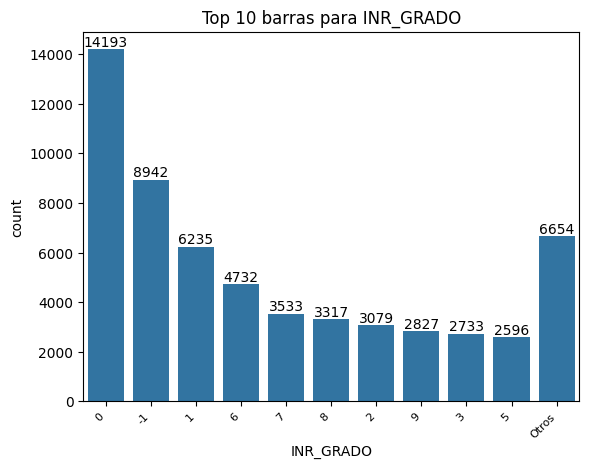

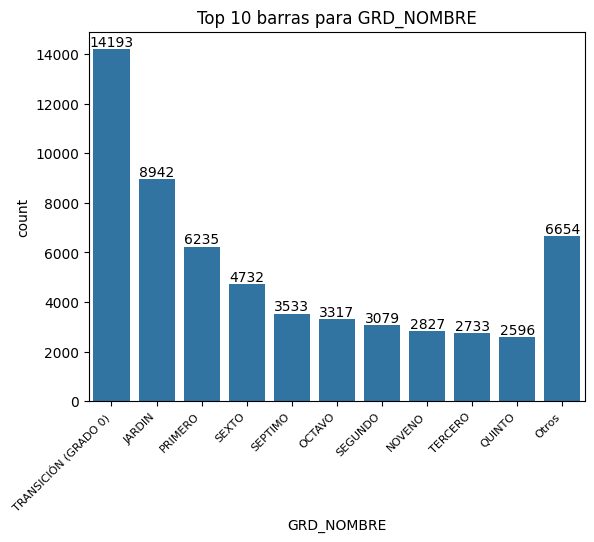

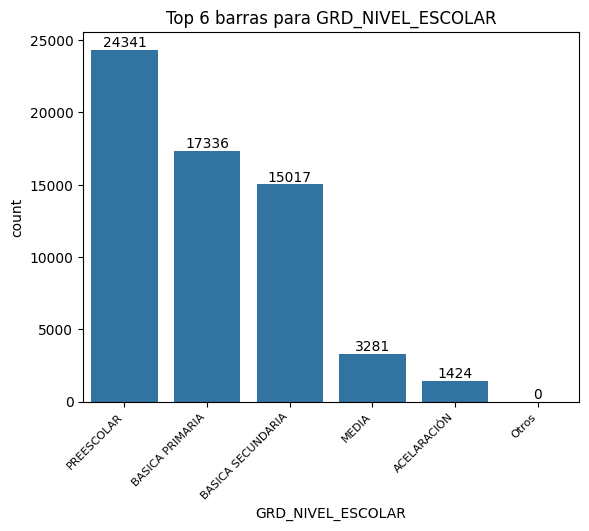

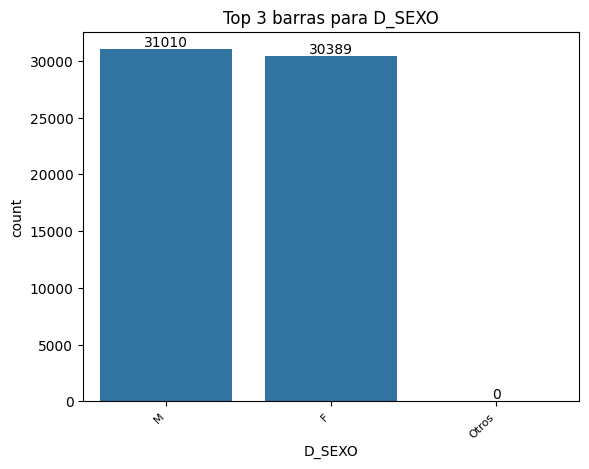

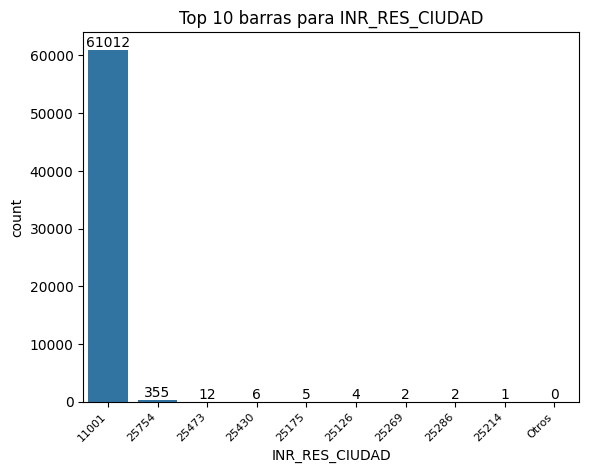

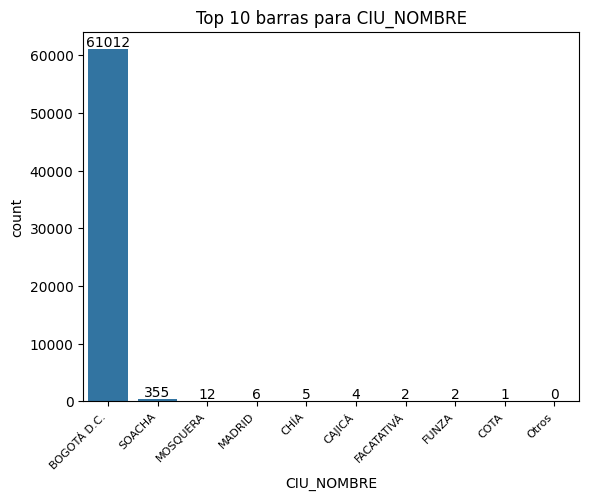

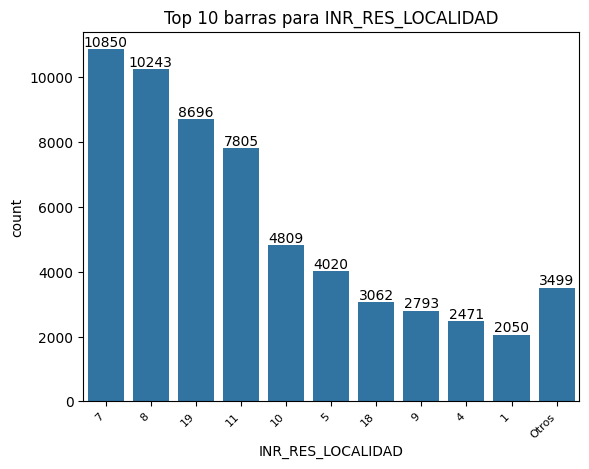

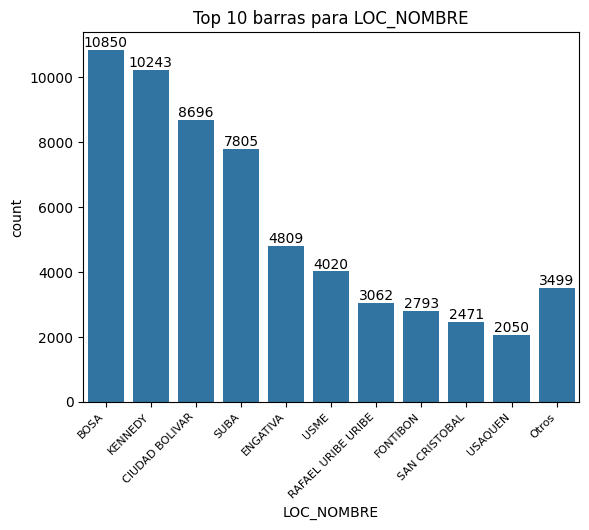

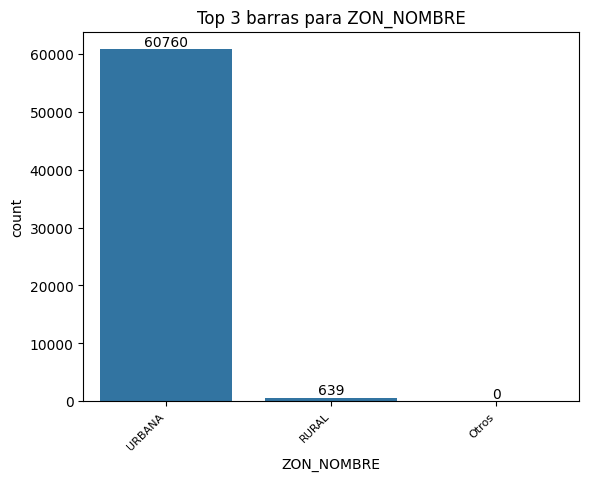

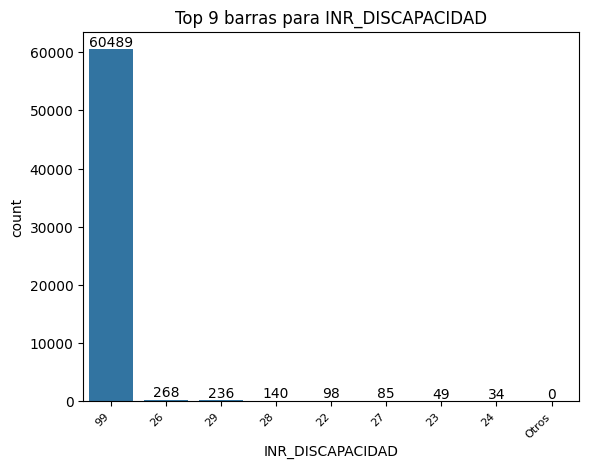

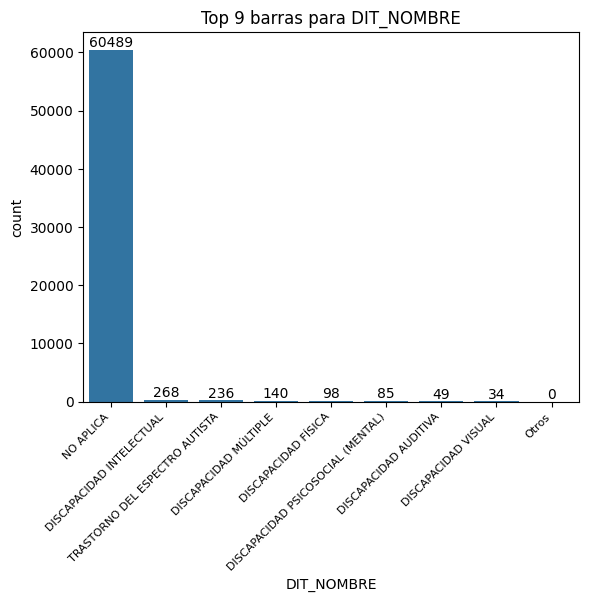

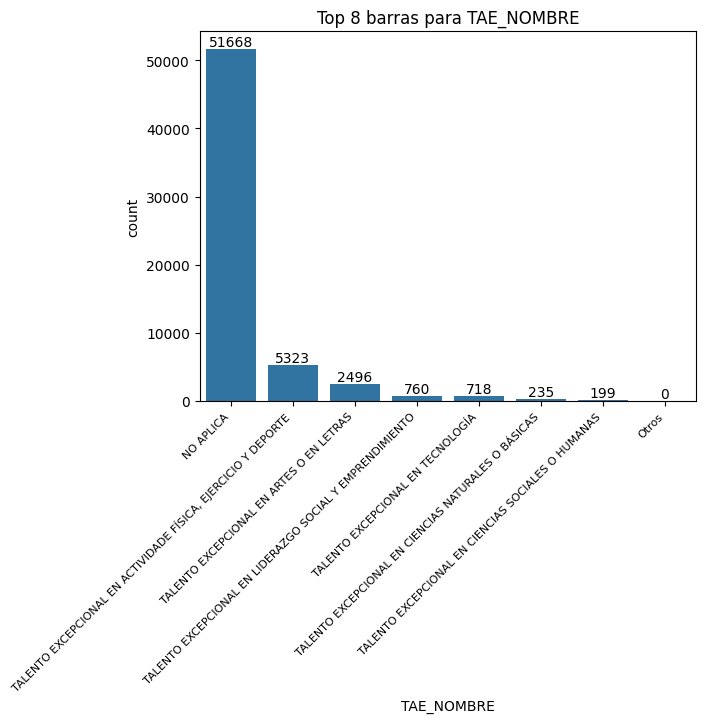

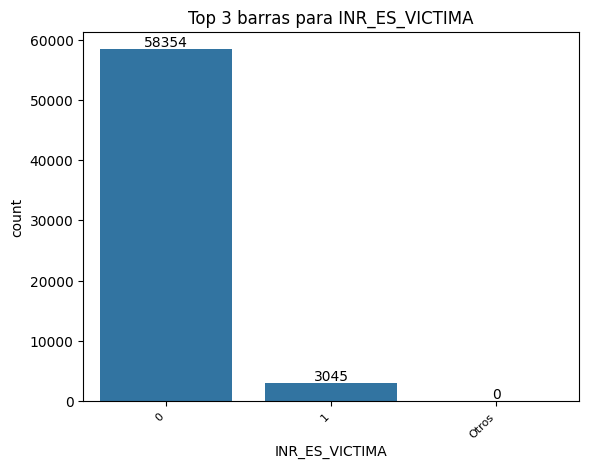

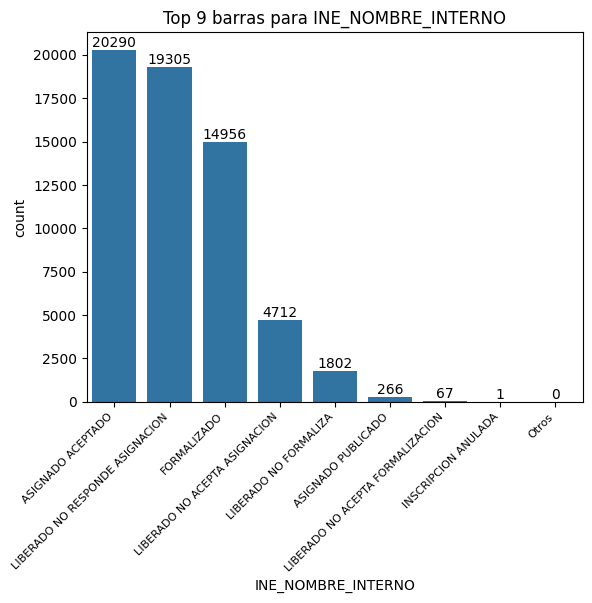

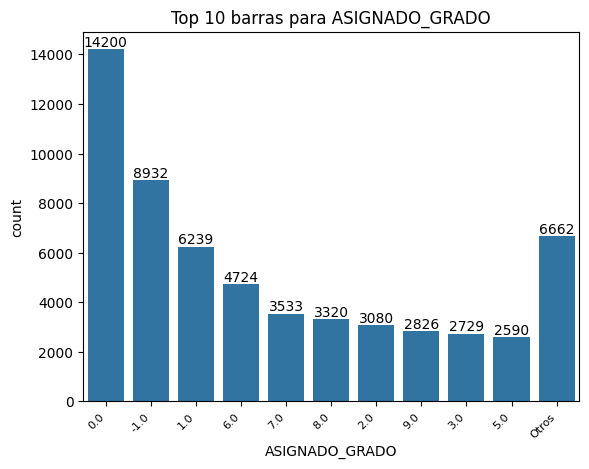

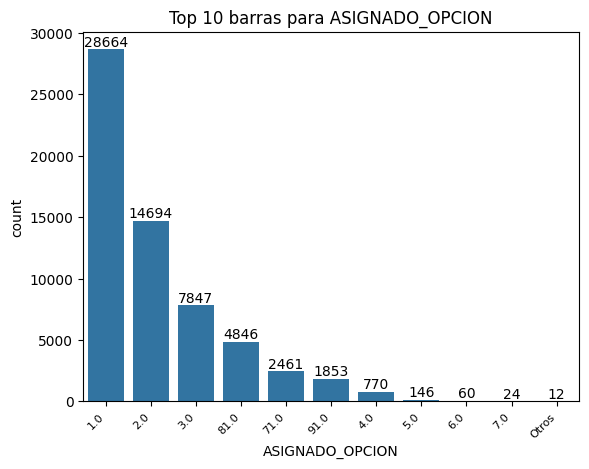

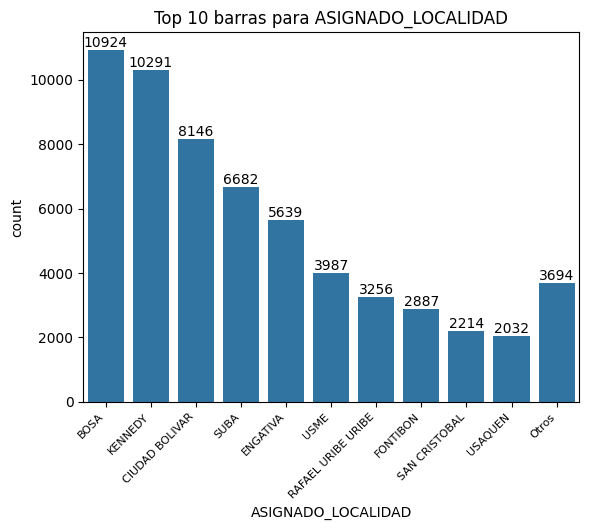

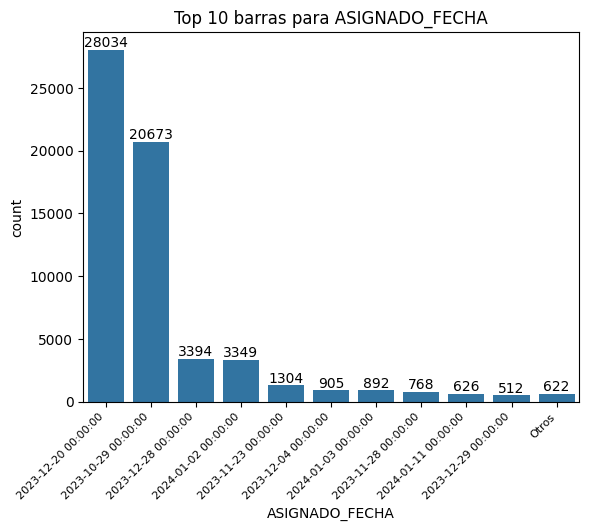

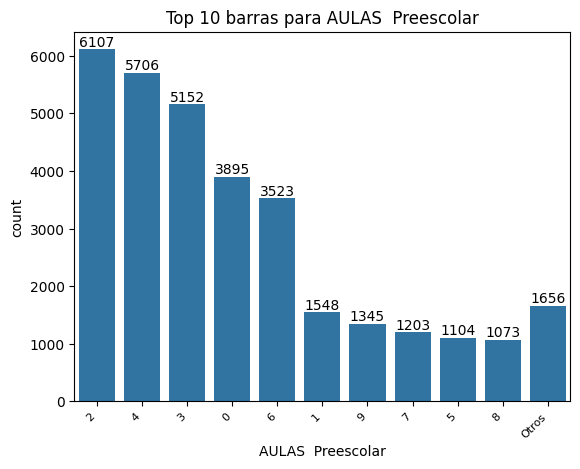

In [187]:
for col in df.columns:
    if len(df[col].unique()) < 25:
        try:
            topn_bars(col, min(len(df[col].unique())+1,10))
        except:
            continue



#### 1.5 Análisis Bivariado

#### 1.5.1 Análisis bivariado categóricas vs Puntaje ICFES

In [188]:
def categories_vs_y(col,n, y):
    df2 = df[~df[y].isna()]
    test = df2[col].value_counts().reset_index()
    test = test.iloc[:n]
    test[col] = test[col].astype(df2[col].dtype)
    data2 = df2[[col,y]].merge(test, on = col , how = 'left')
    data2[col] = data2[col].astype('object')
    data2.loc[data2['count'].isna(), col] = 'Otros'
    plt.figure(figsize=(10,5))
    ax = sns.violinplot( data = data2, x= col, y = y, inner = None, saturation = 0.5)
    sns.boxplot(data=data2, x= col, y=y, saturation=0.5, width=0.4,
                hue = col, legend = False, boxprops={'zorder': 2}, ax=ax)
    plt.title(f'{y} vs {col} considering only top {n} categories', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel(f'{y}', fontsize=12)
    plt.xticks(rotation = 45, ha='right')
    plt.show()

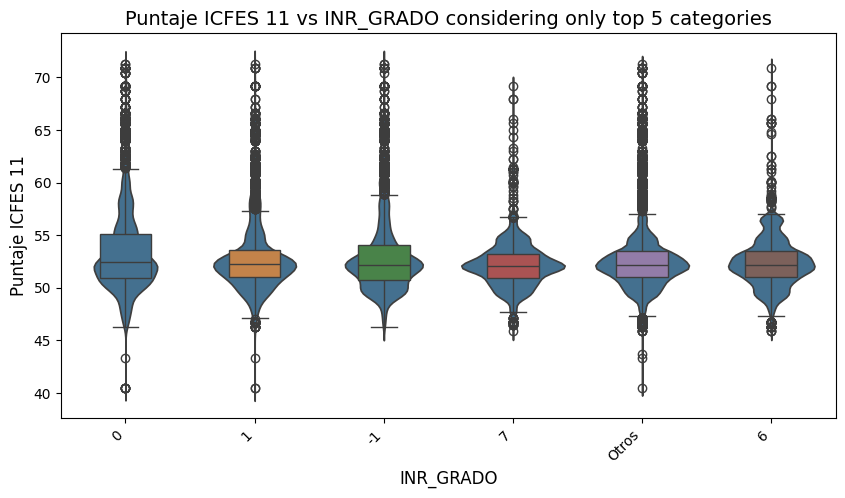

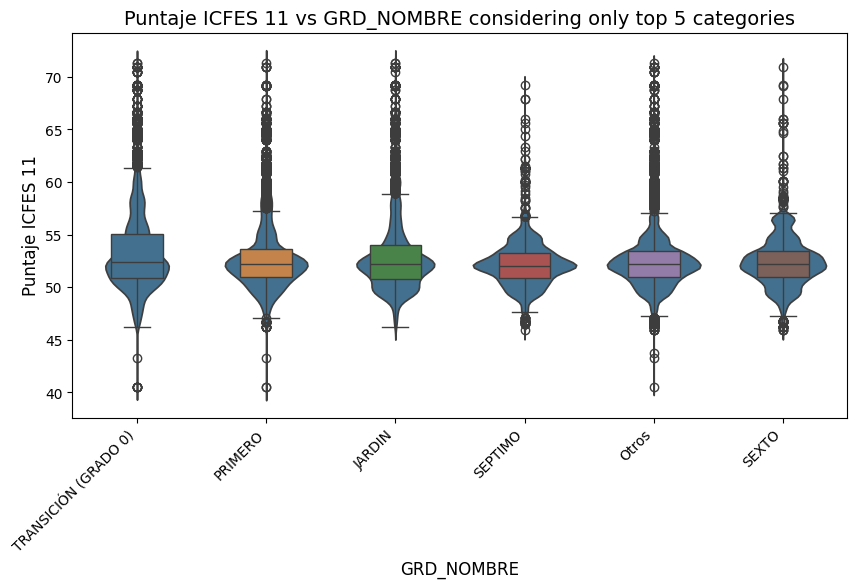

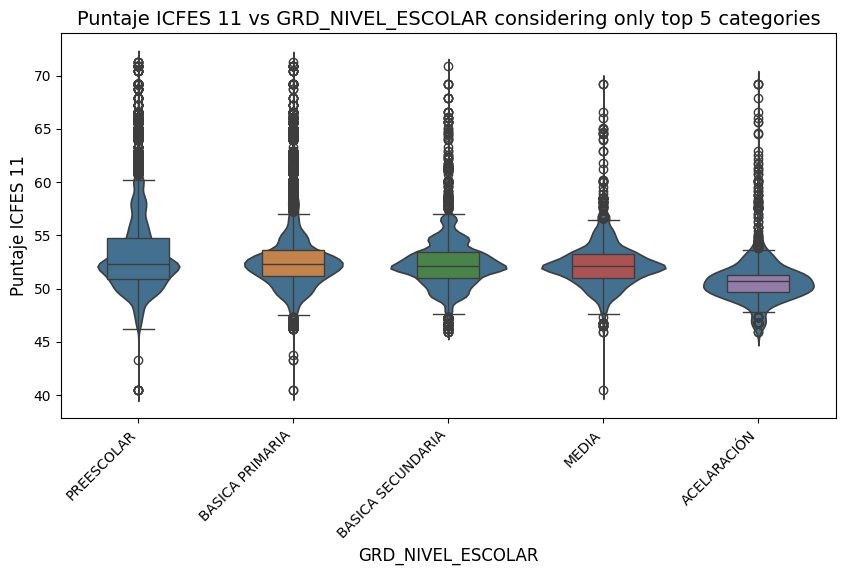

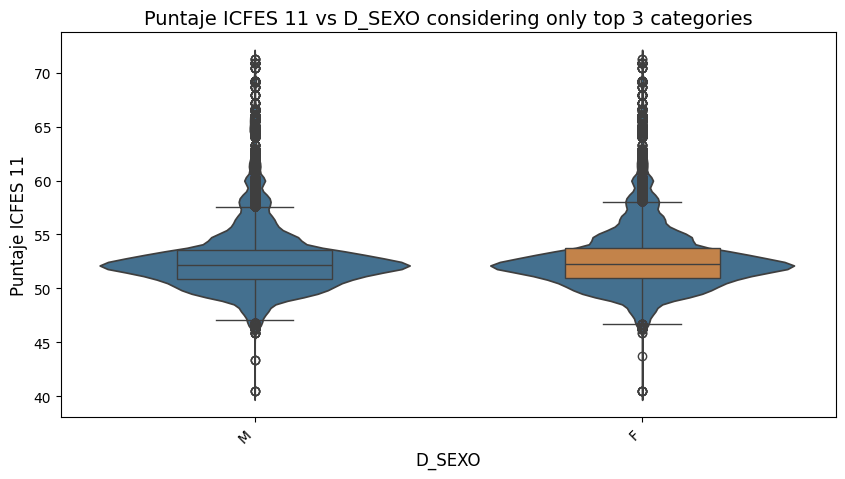

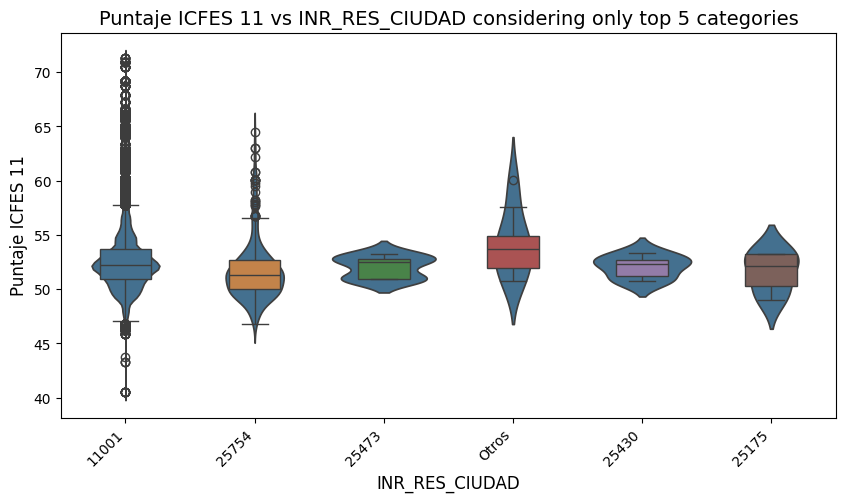

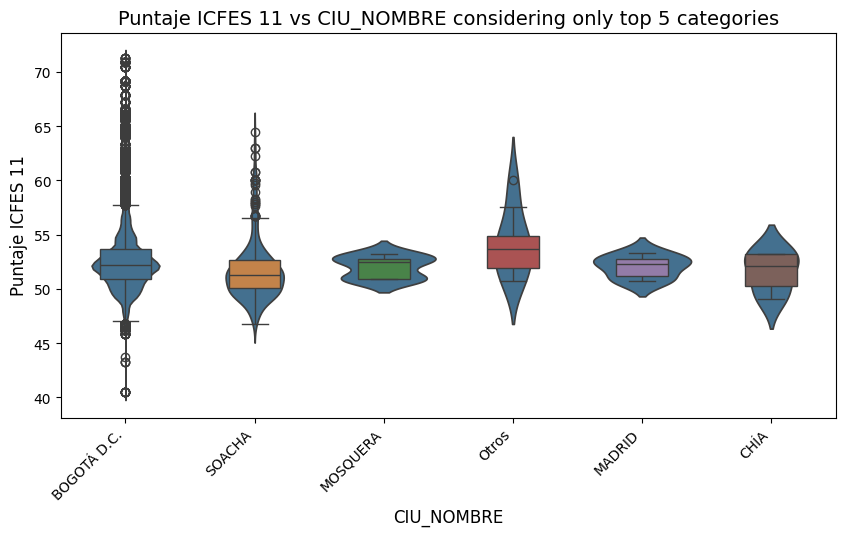

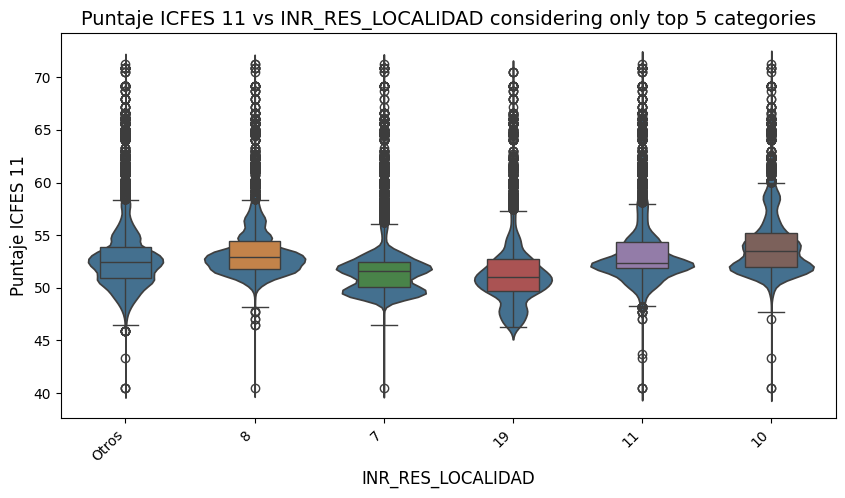

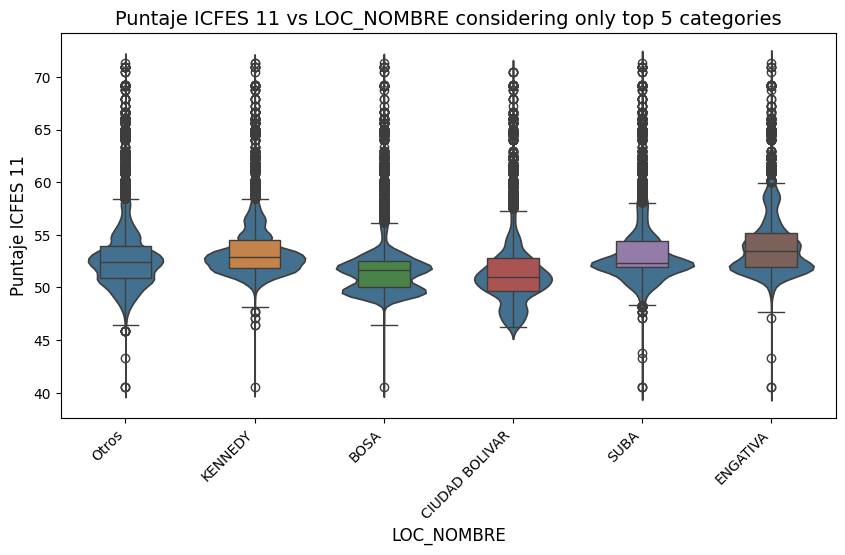

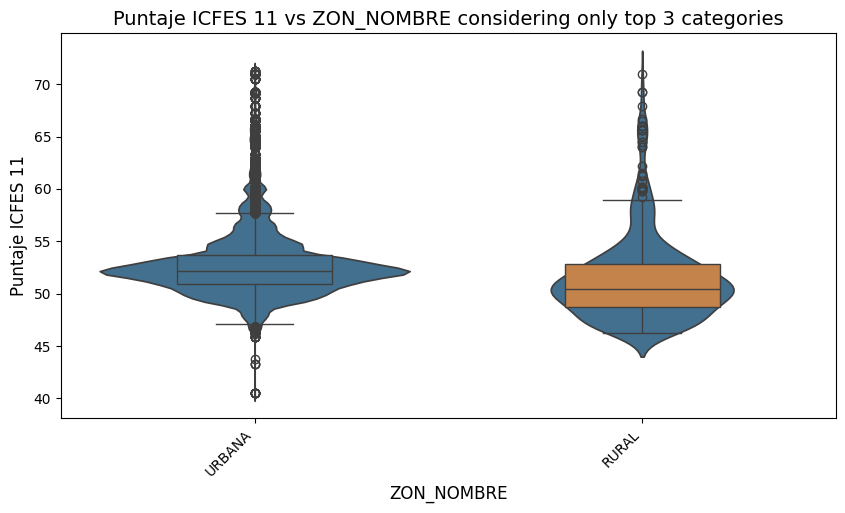

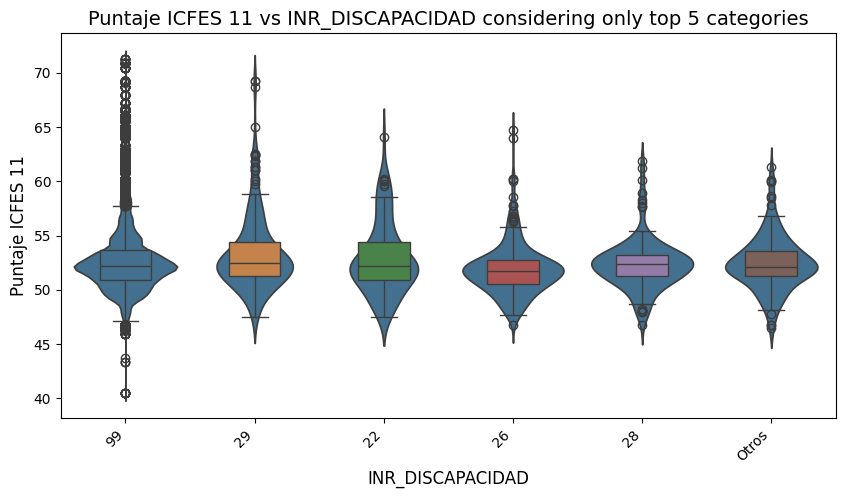

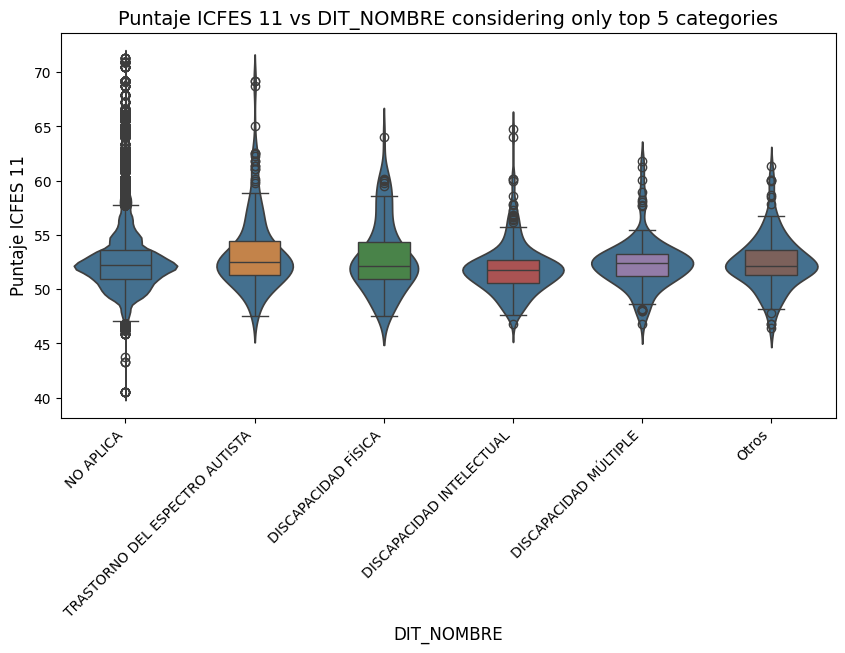

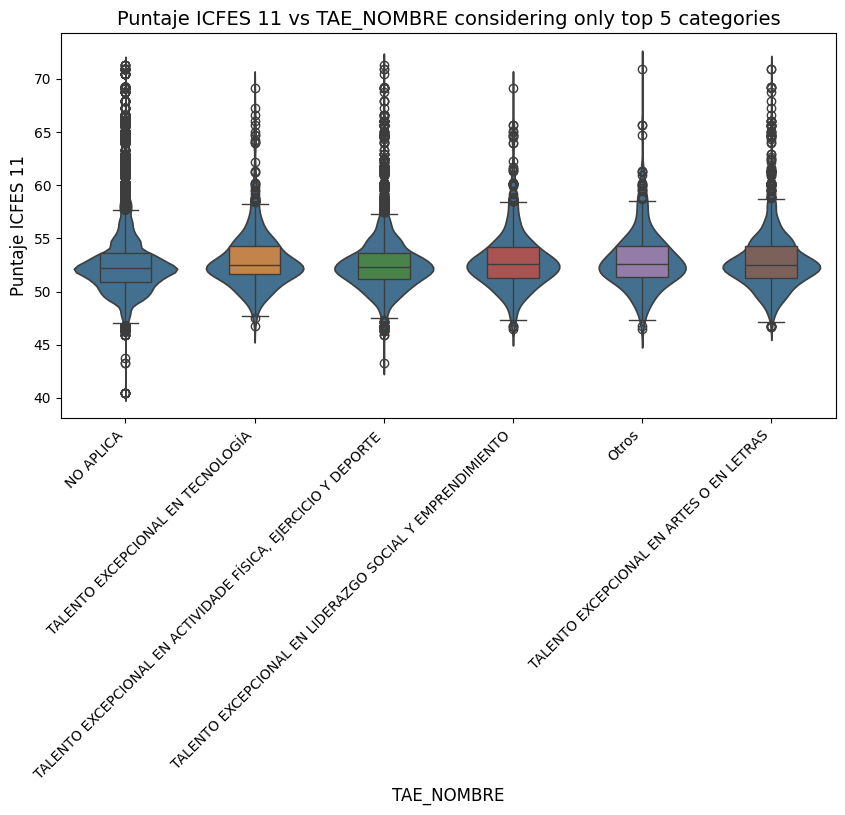

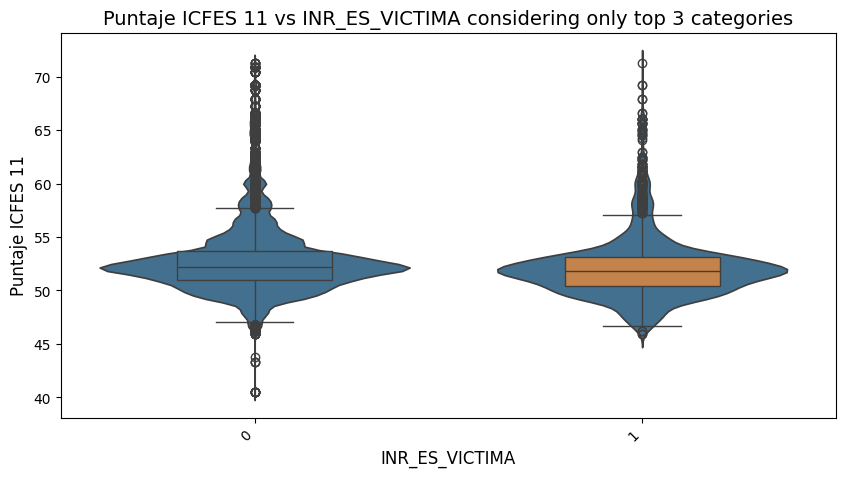

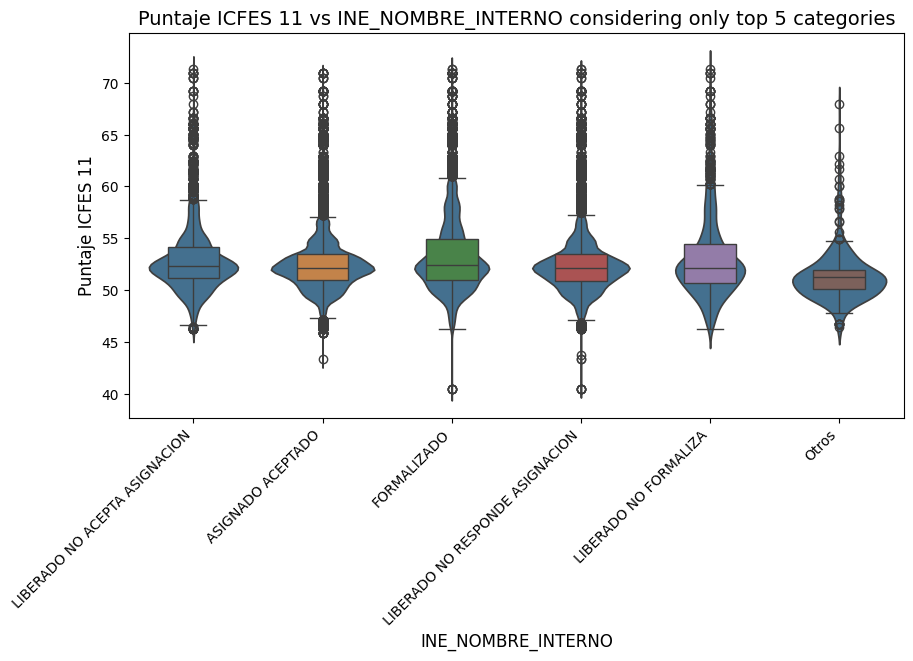

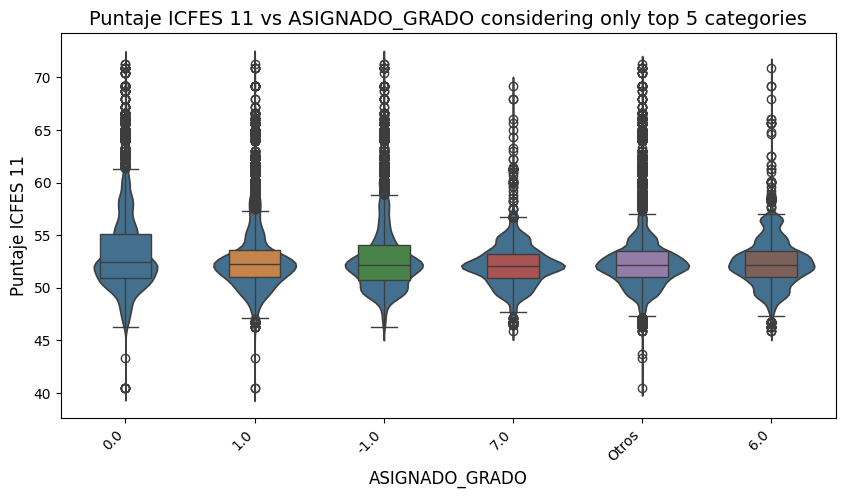

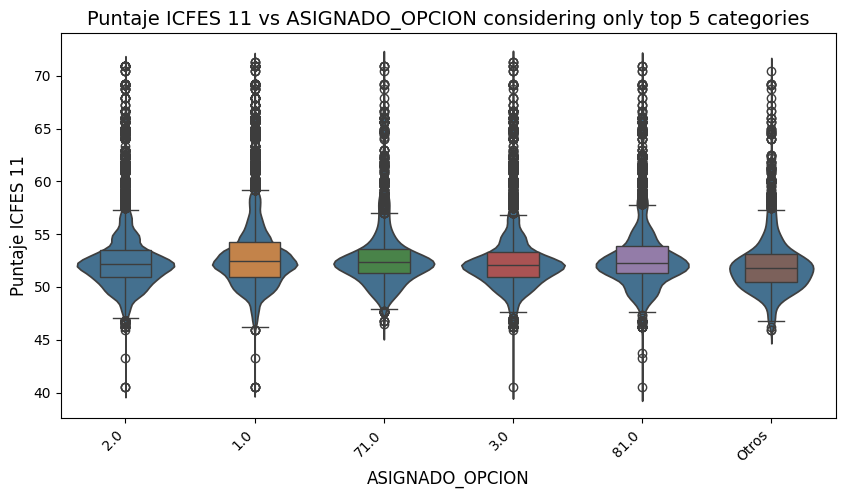

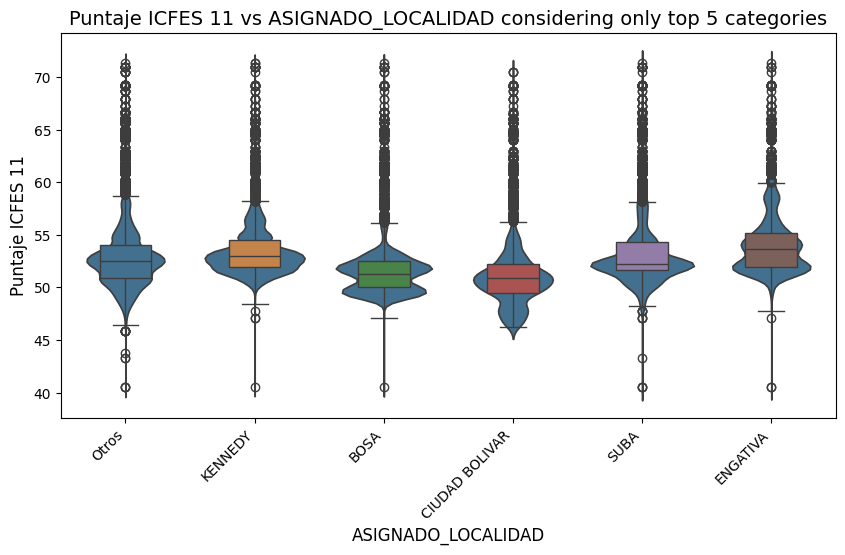

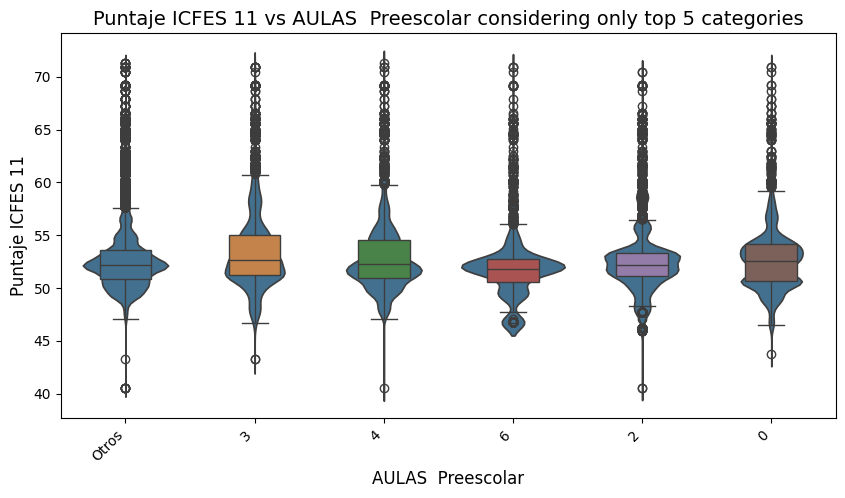

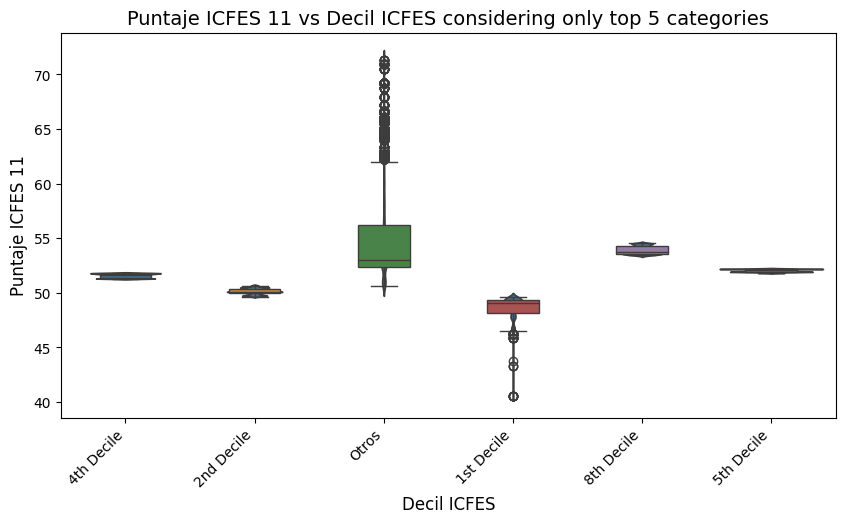

In [189]:
for col in df.columns:
    if (len(df[col].unique()) < 25) & (df[col].dtype != '<M8[ns]'):
        try:
            categories_vs_y(col, min(len(df[col].unique())+1,5), 'Puntaje ICFES 11')
        except:
            continue

#### 1.5.2 Análisis bivariado categoricas vs Capacidad

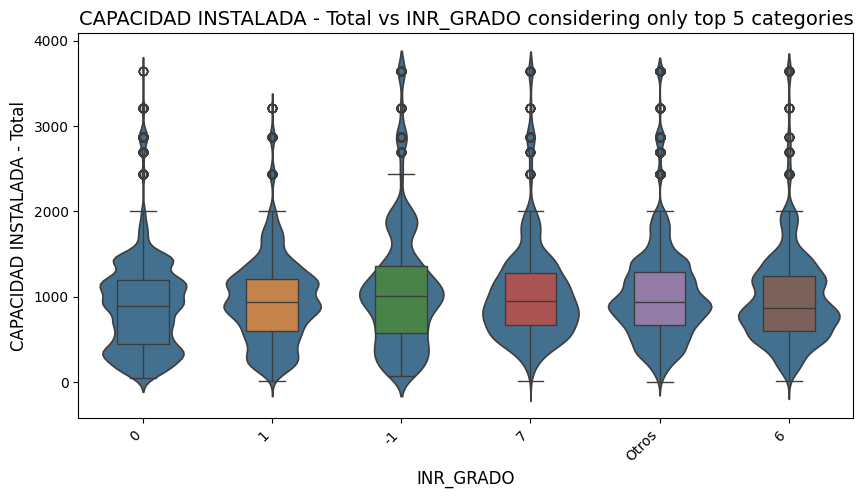

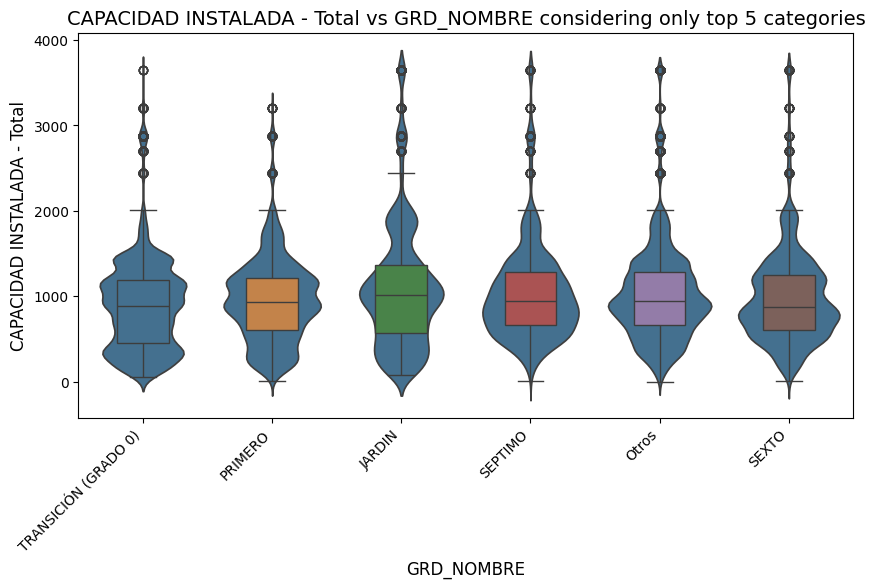

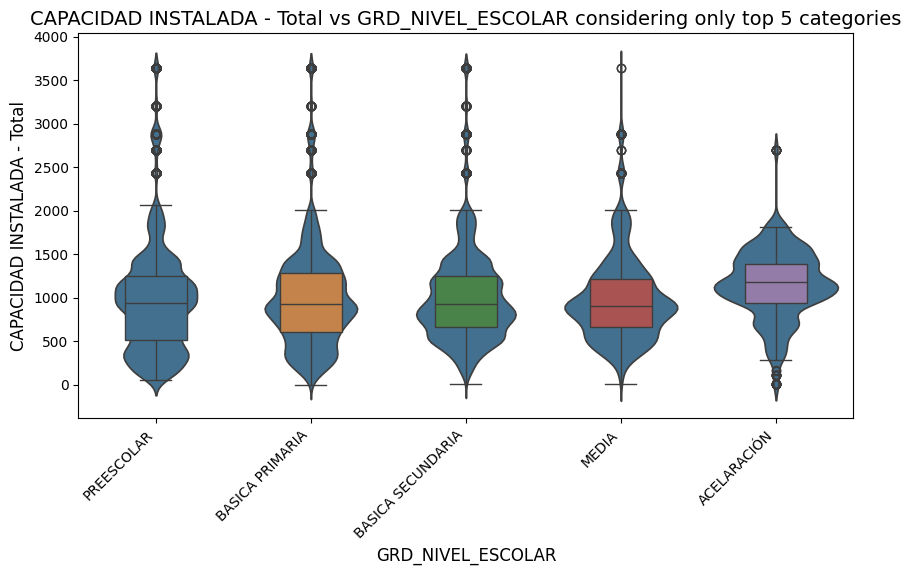

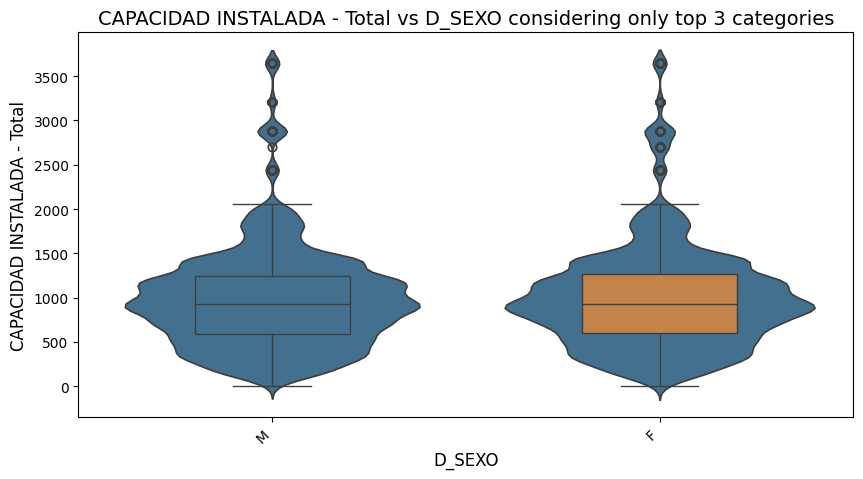

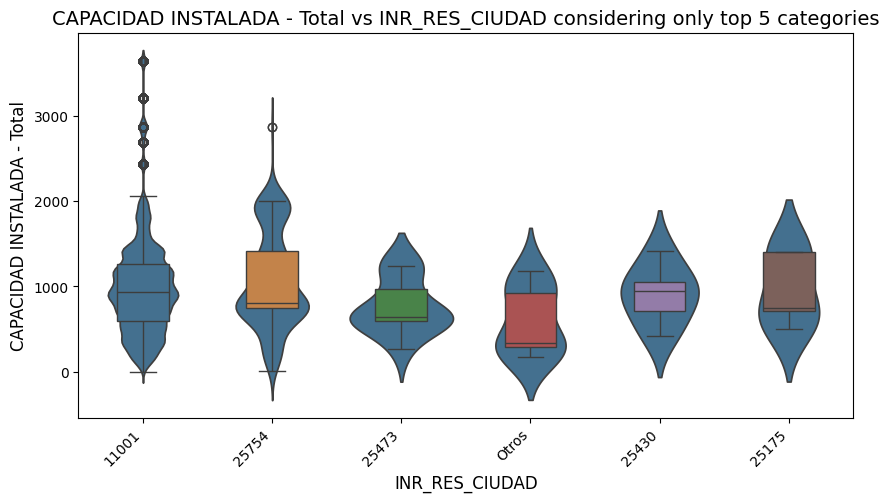

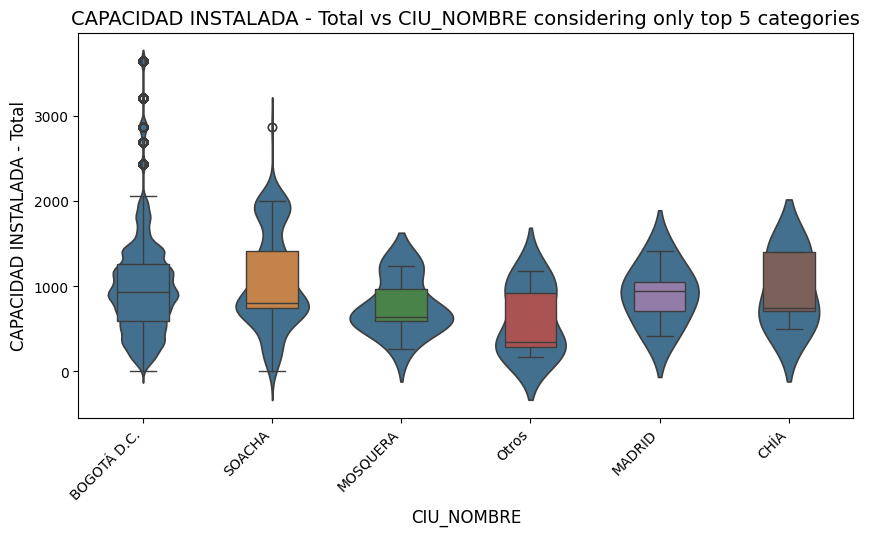

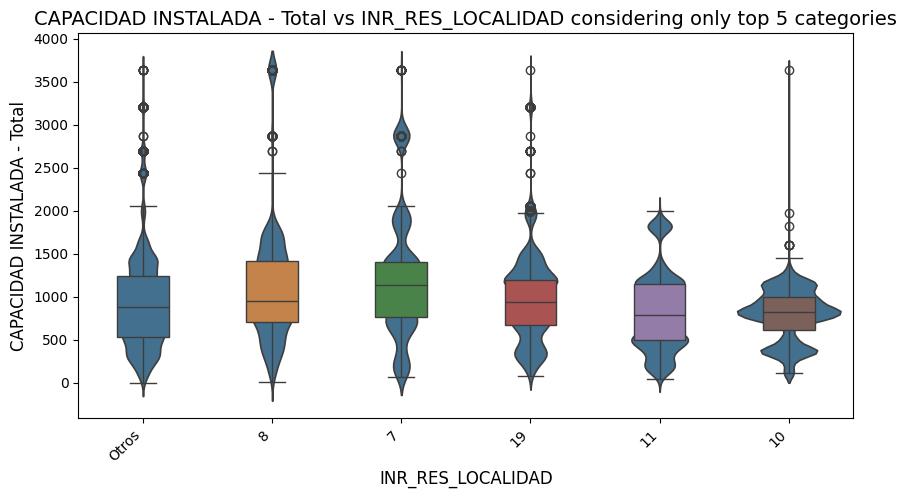

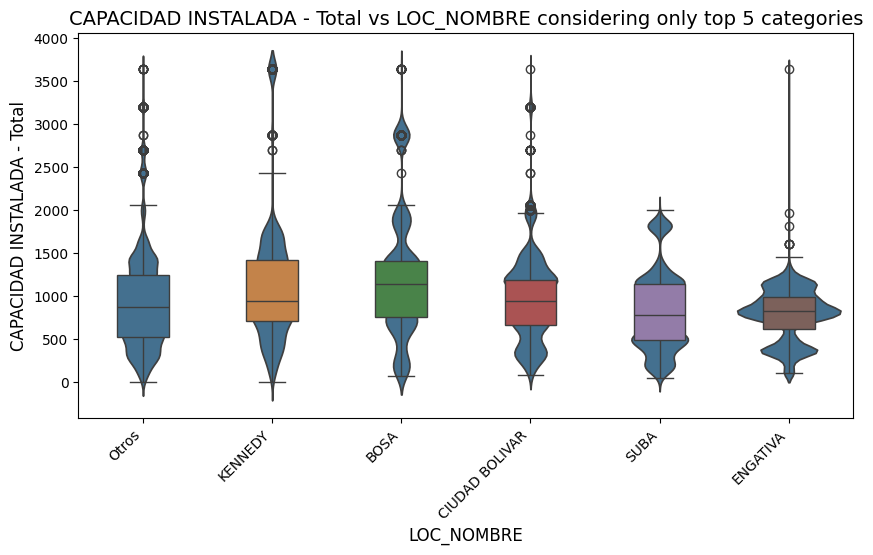

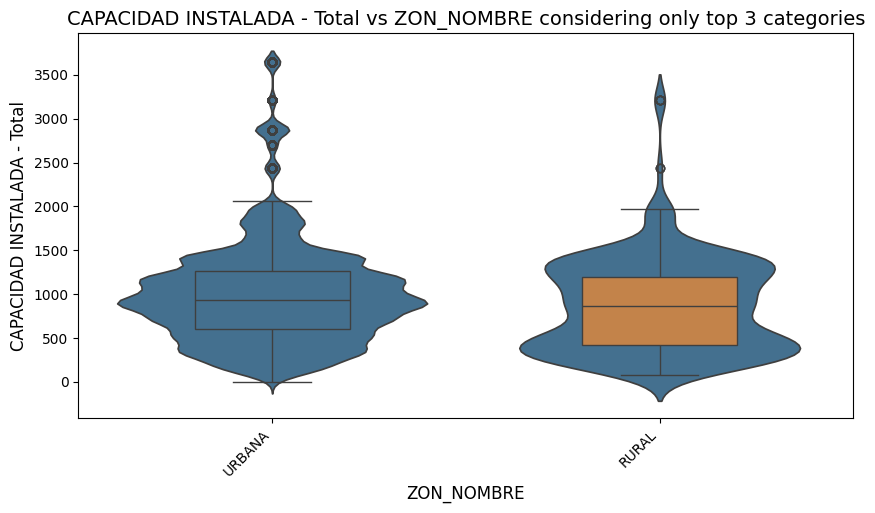

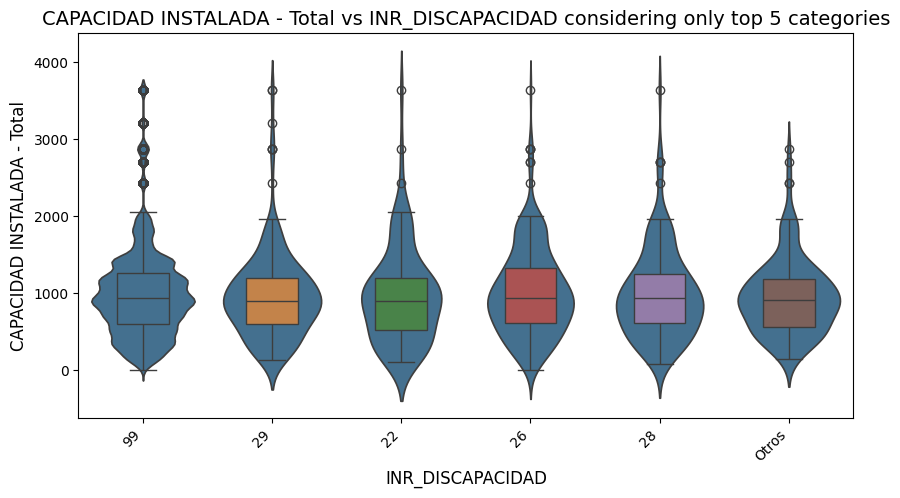

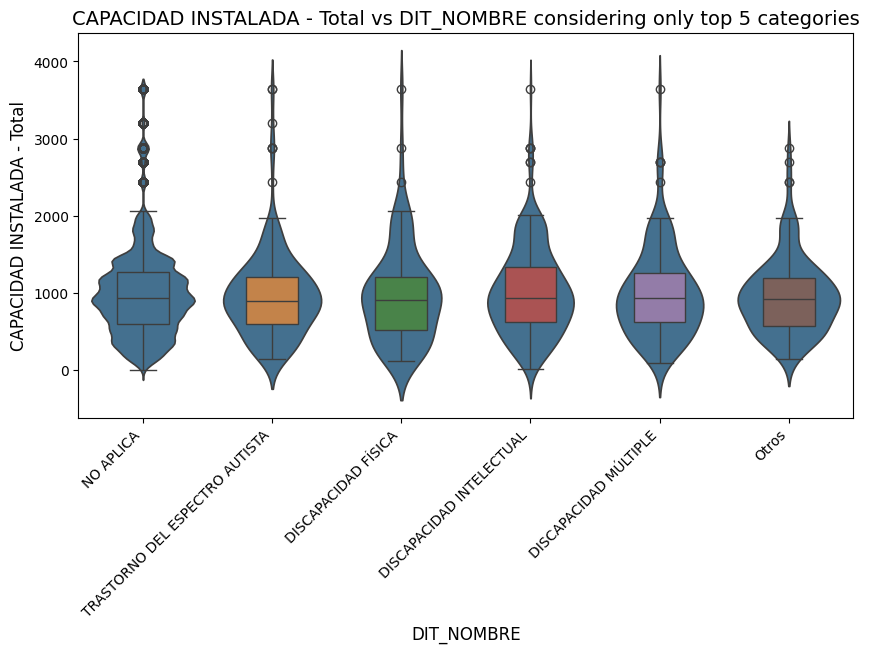

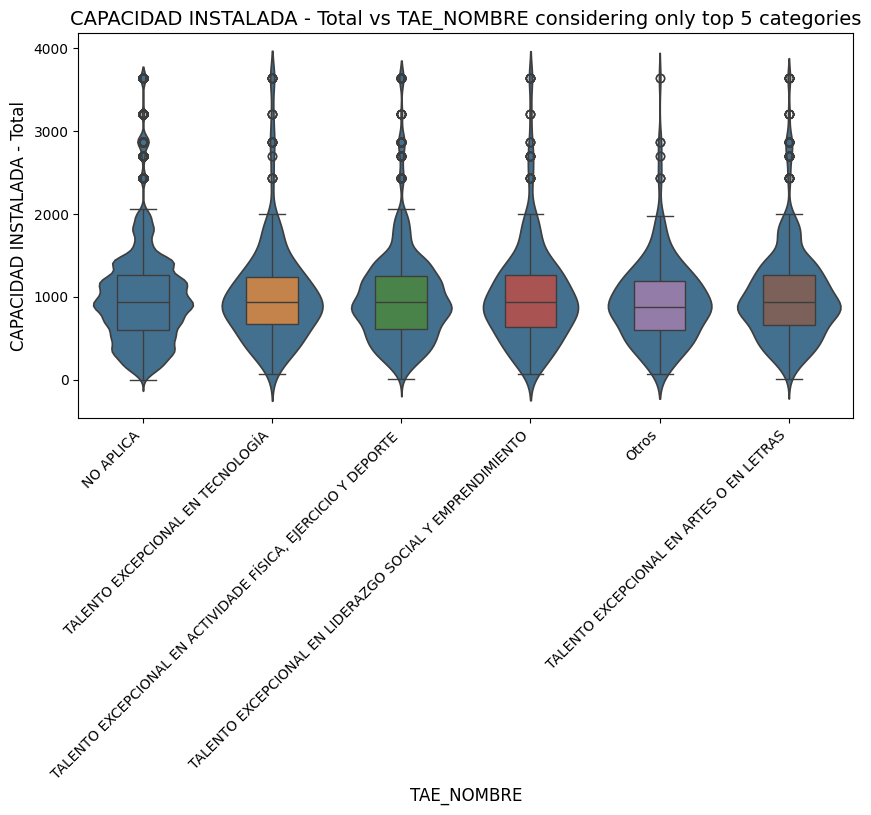

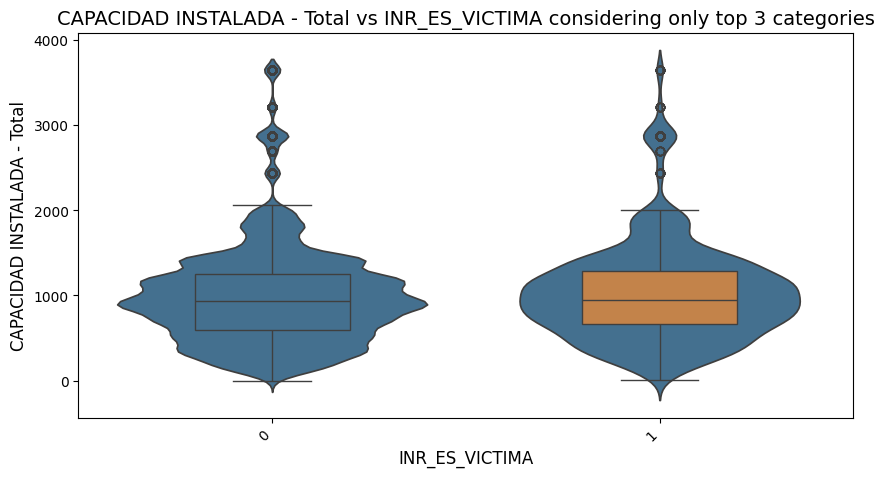

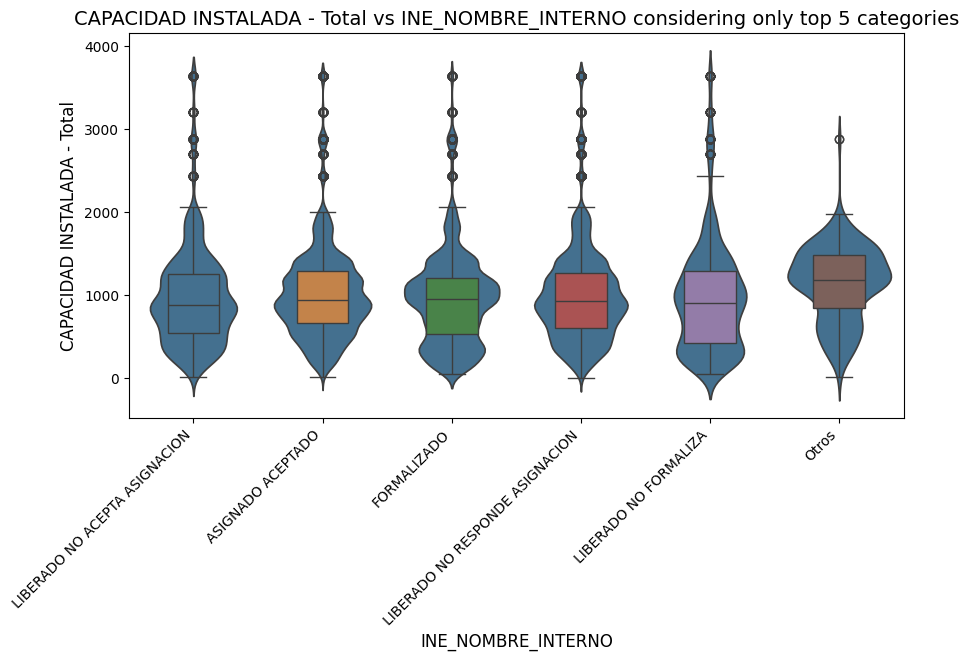

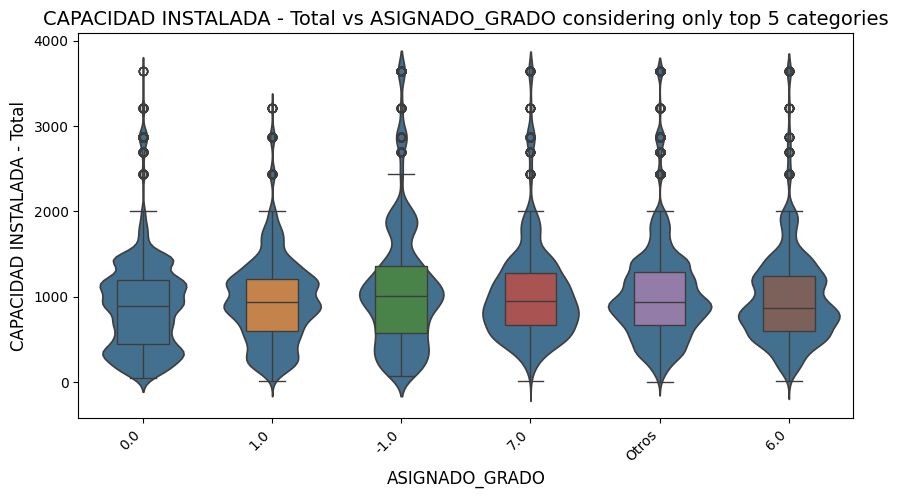

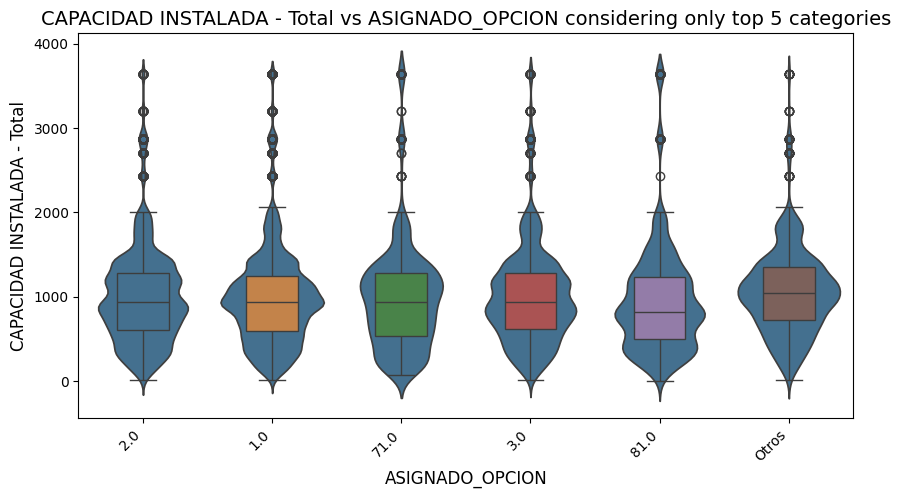

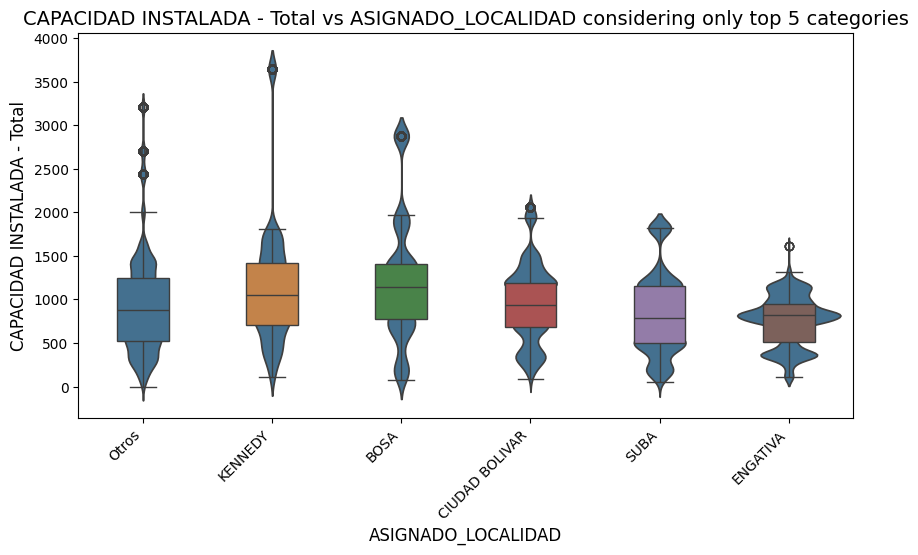

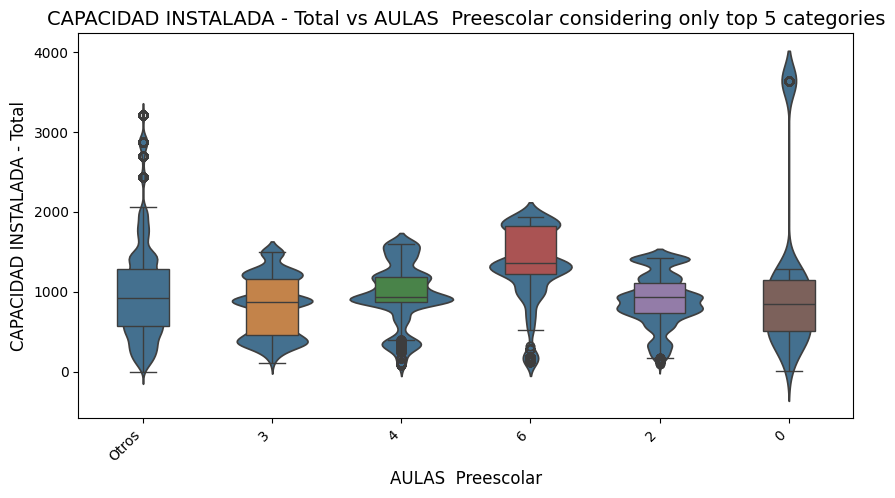

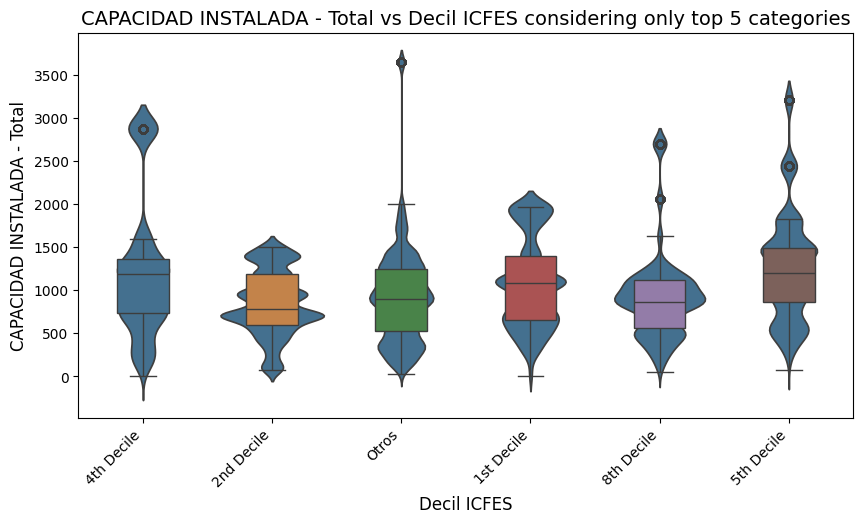

In [190]:
for col in df.columns:
    if (len(df[col].unique()) < 25) & (df[col].dtype != '<M8[ns]'):
        try:
            categories_vs_y(col, min(len(df[col].unique())+1,5), 'CAPACIDAD INSTALADA - Total')
        except:
            continue

#### 1.5.3 Análisis tablas de Frecuencia categorias vs Deciles ICFES

In [191]:
import warnings
warnings.filterwarnings("ignore")

In [192]:
def tablaFrecuenciasTopn(col, n, y):
    base = df[col].value_counts()[:n]
    suma_otros = df[col].value_counts()[n:].sum()
    s = pd.concat([base,pd.Series(  {'Otros':suma_otros})]).rename('counts').reset_index().rename(columns = {'index': col})
    d = df.groupby([col, y]).size().rename('Frecuencia').reset_index()
    d[col] = d[col].astype(s[col].dtype)
    m = d.merge(s, on = col, how= 'left')
    m.loc[m['counts'].isna(), col] = 'Otros'
    m = m.drop( columns = ['counts'])
    m[col] = m[col].astype('str')
    
    data = pd.pivot_table(m, values='Frecuencia',  index = [col], columns=y, aggfunc='sum')
    data = data / data.sum().sum()
    plt.figure(figsize=(10,4))
    plt.title(f'Tabla de frecuencias para {col} vs {y}')
    sns.heatmap(data, annot= True, fmt=".2%",cmap='Oranges')
    plt.xticks(rotation = 45, ha = 'right')
    plt.show()



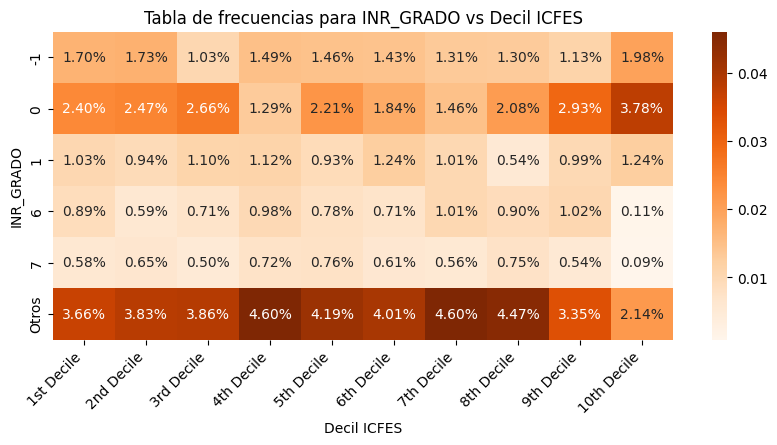

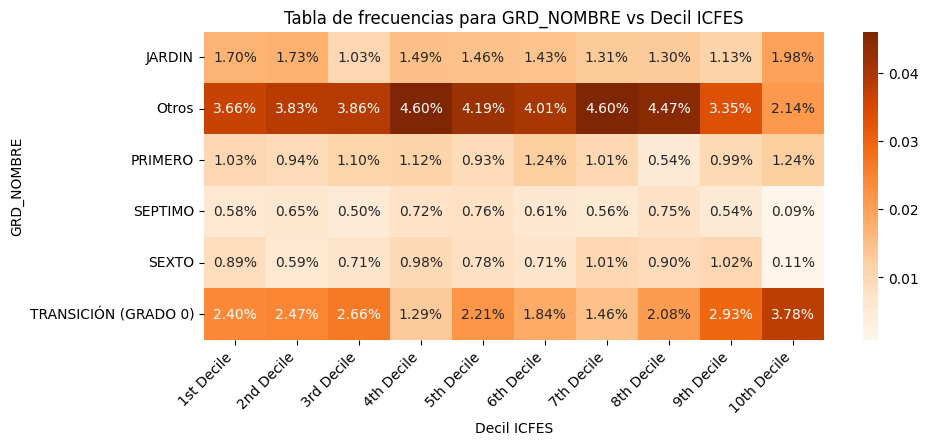

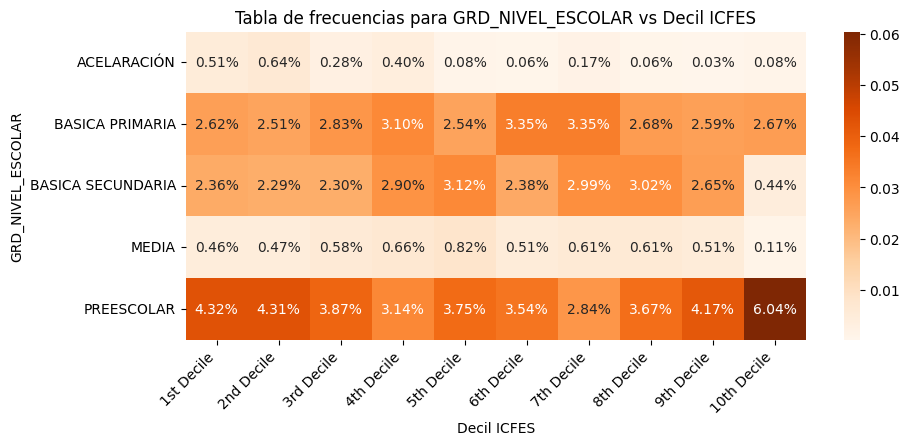

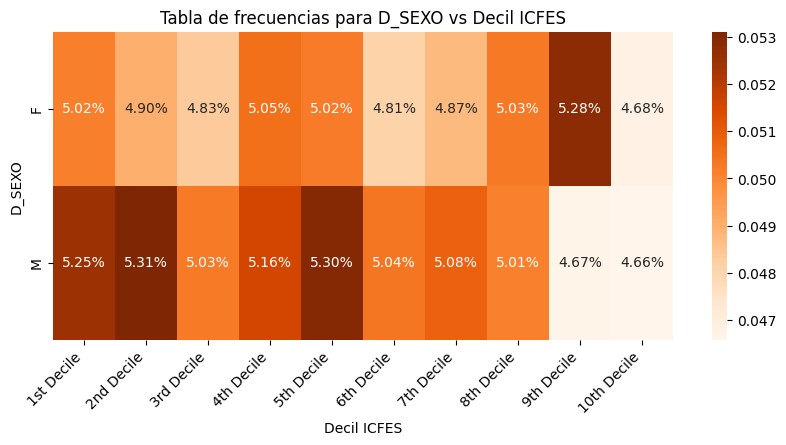

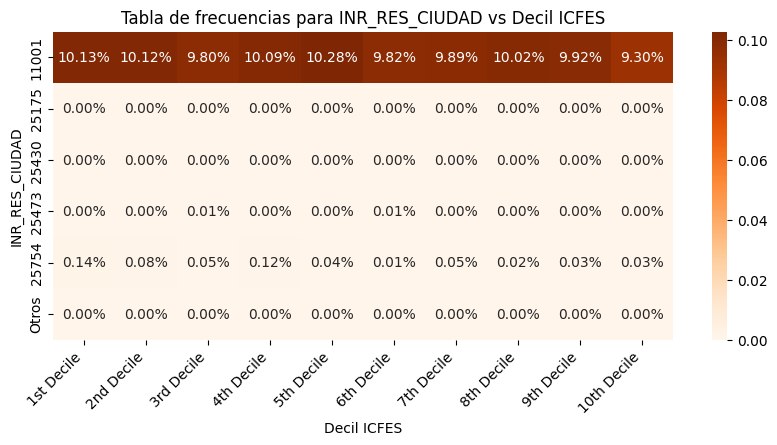

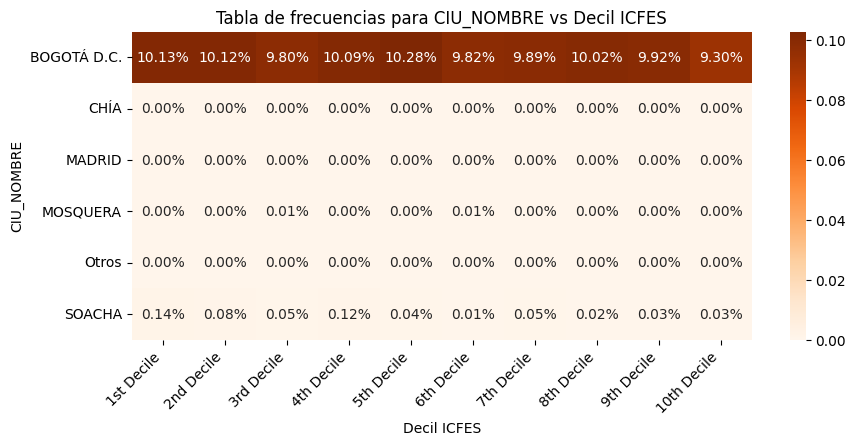

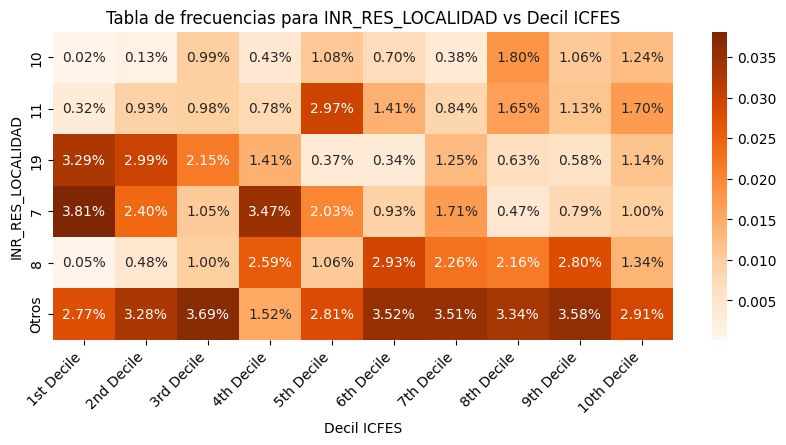

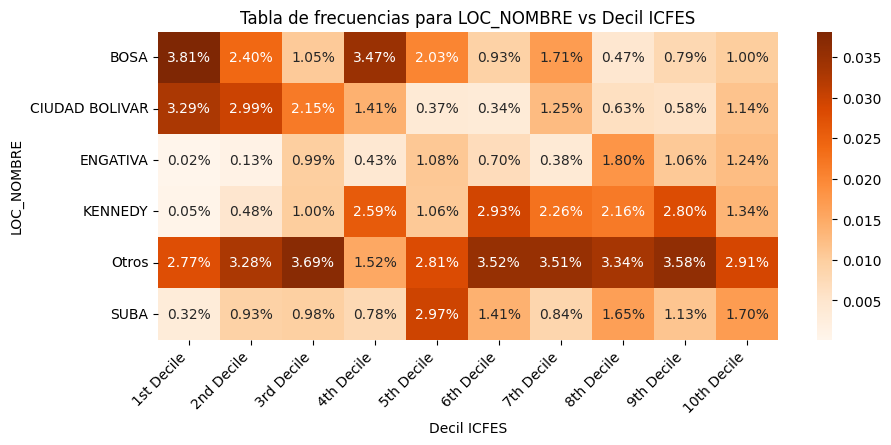

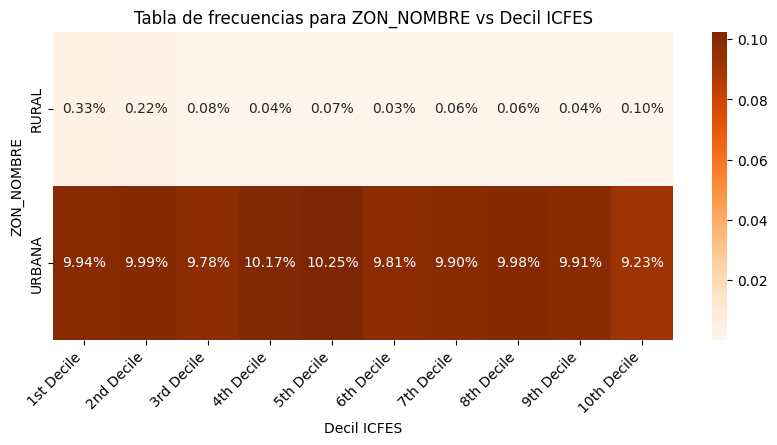

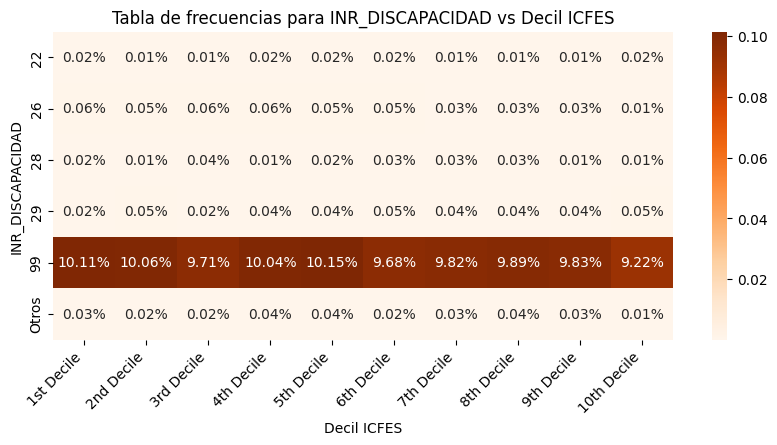

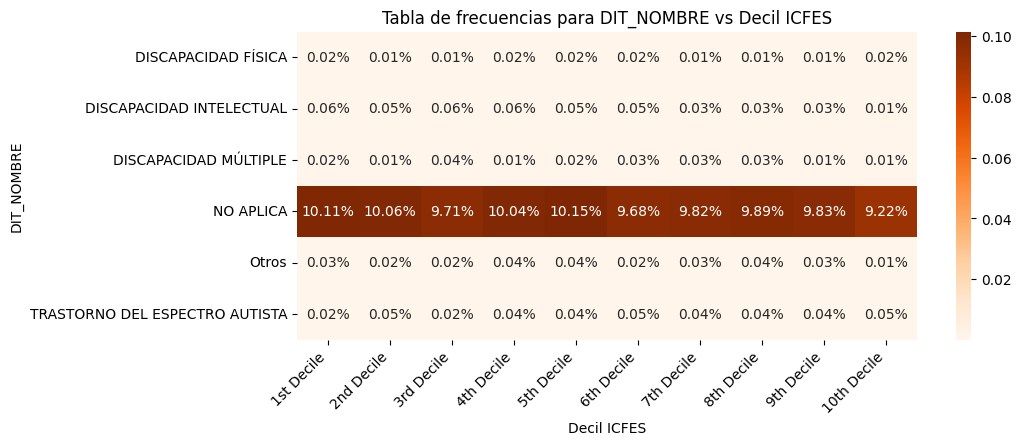

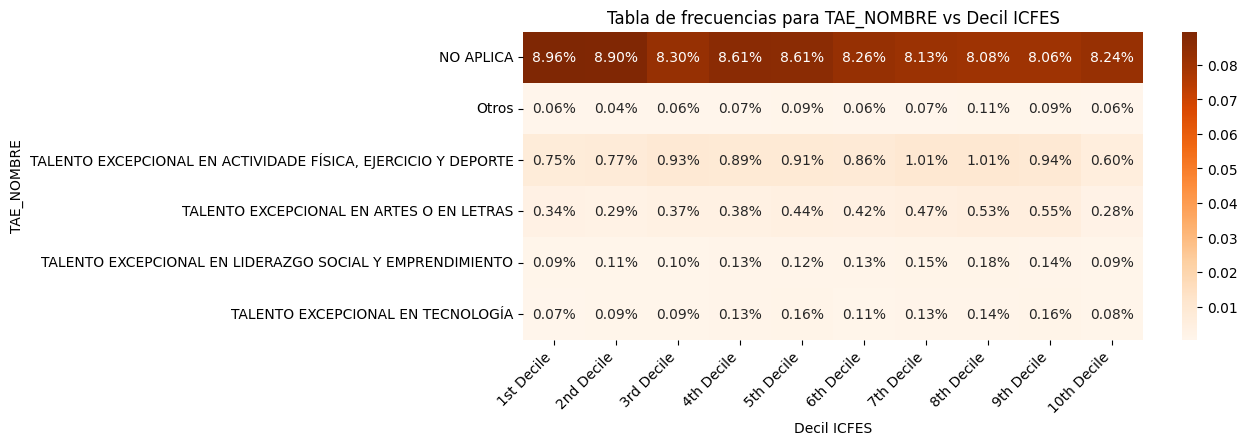

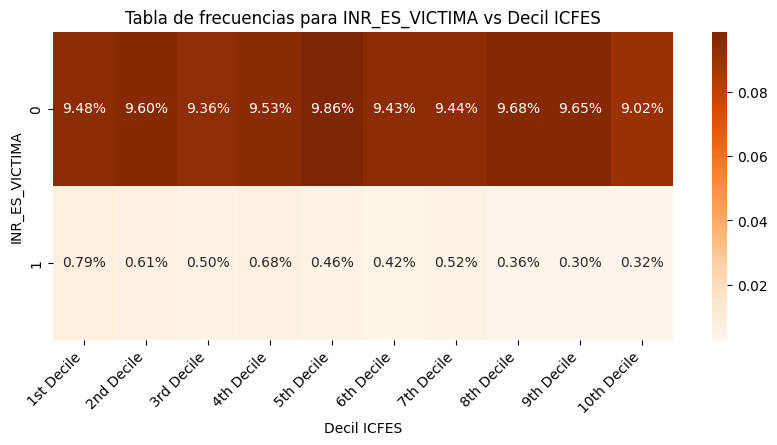

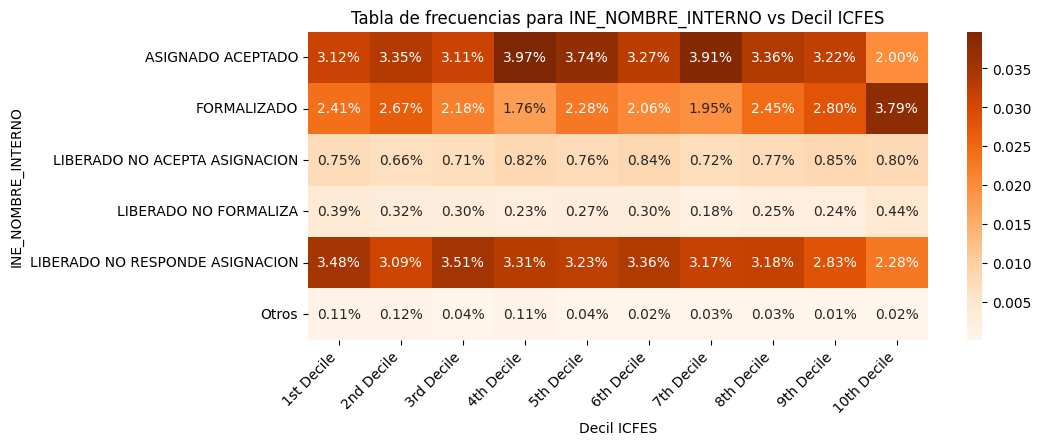

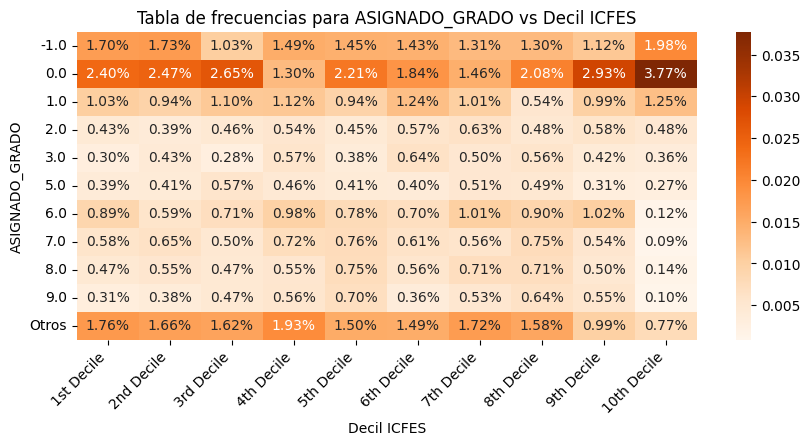

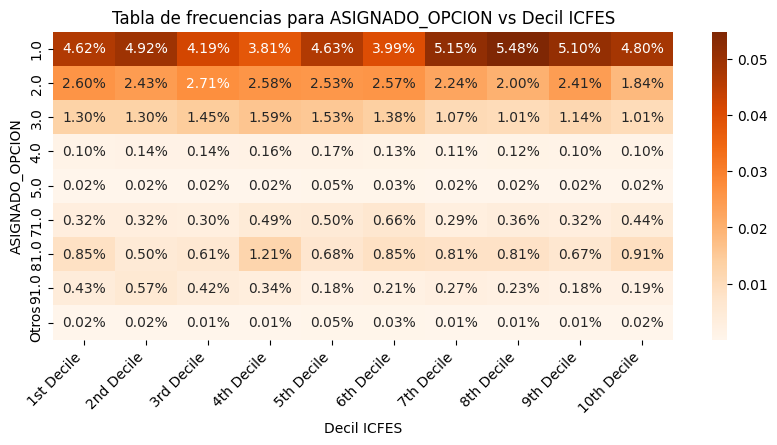

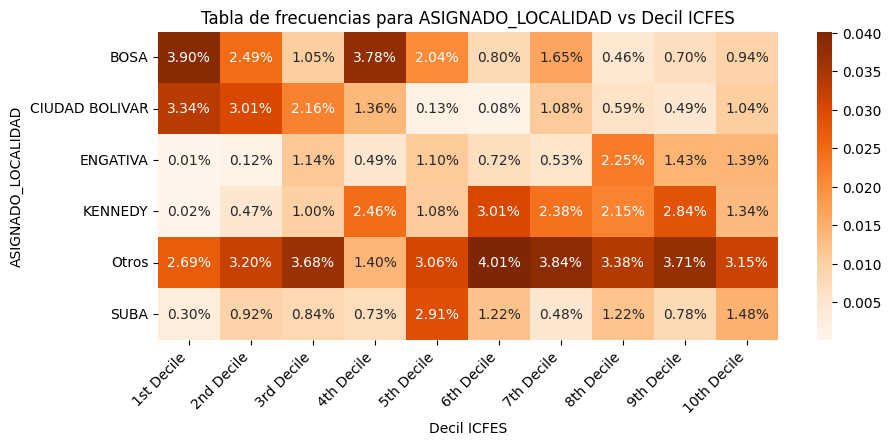

In [193]:
for col in df.columns:
    if (len(df[col].unique()) < 25) & (df[col].dtype != '<M8[ns]'):
        try:
            tablaFrecuenciasTopn(col, min(len(df[col].unique())+1,5), 'Decil ICFES')
        except:
            continue

#### 1.5.4 Análisis especifico

In [194]:
## Hisogramas
def historam(var):
    
    dataHist = df[var]
    n, bins, patches = plt.hist(x=dataHist, bins='auto', color='#98002E',alpha=0.7, rwidth=0.85)
    maxfreq = n.max()
    maxval = dataHist.min() + (dataHist.max() - dataHist.min())*0.69
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Rangos de datos Hearth Failure')
    plt.ylabel(f'{var}')
    plt.title(f'Distribution {var}')
    plt.text(maxval, maxfreq * 1.15, f'$\mu={round(dataHist.mean(),1)},$ $\sigma={round(dataHist.std(),1)}$')
    plt.text(maxval, maxfreq * 1.1, f'$Q_1={round(dataHist.quantile(q=0.25),1)},$ $Q_2={round(dataHist.quantile(q=0.5),1)},$ $Q_3={round(dataHist.quantile(q=0.75),1)}$')
    plt.text(maxval, maxfreq * 1.05, f'$Min={round(dataHist.min(),1)},$ $Max={round(dataHist.max(),1)}$')
    plt.ylim(ymax= maxfreq*1.3)
    plt.xlim(xmax= dataHist.max() * 1.1)

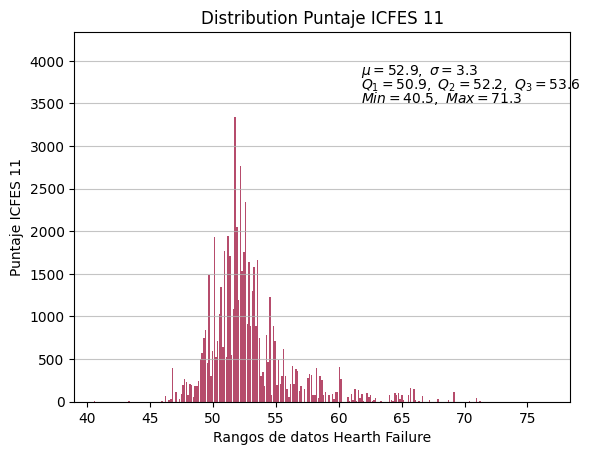

In [197]:
historam('Puntaje ICFES 11')

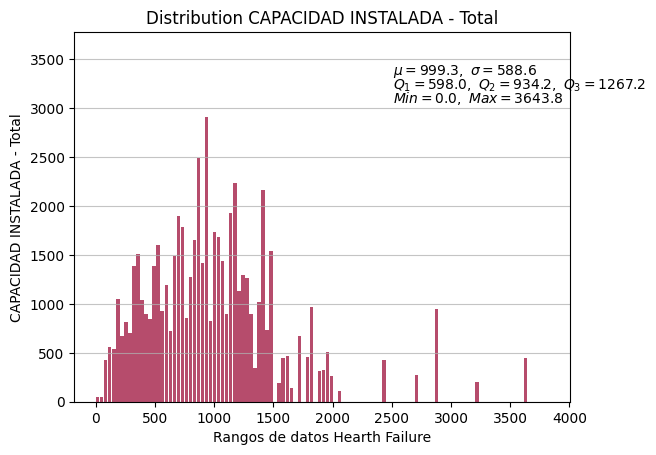

In [198]:
historam('CAPACIDAD INSTALADA - Total')

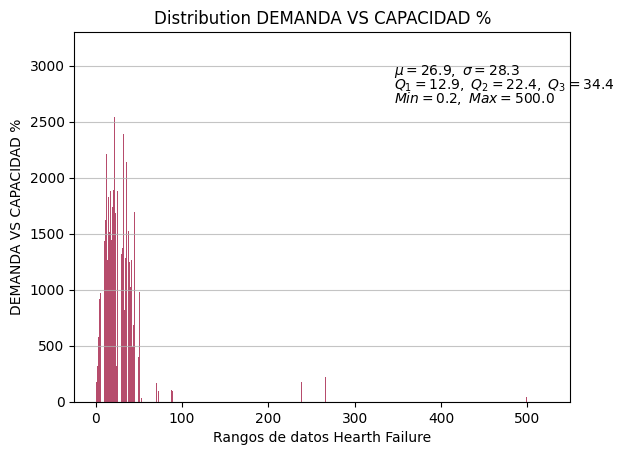

In [199]:
historam('DEMANDA VS CAPACIDAD %')

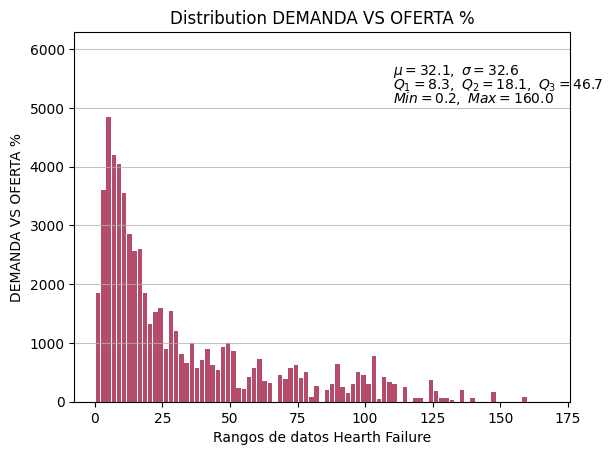

In [201]:
historam('DEMANDA VS OFERTA %')

#### 1.5.5 Graficas seleccionadas

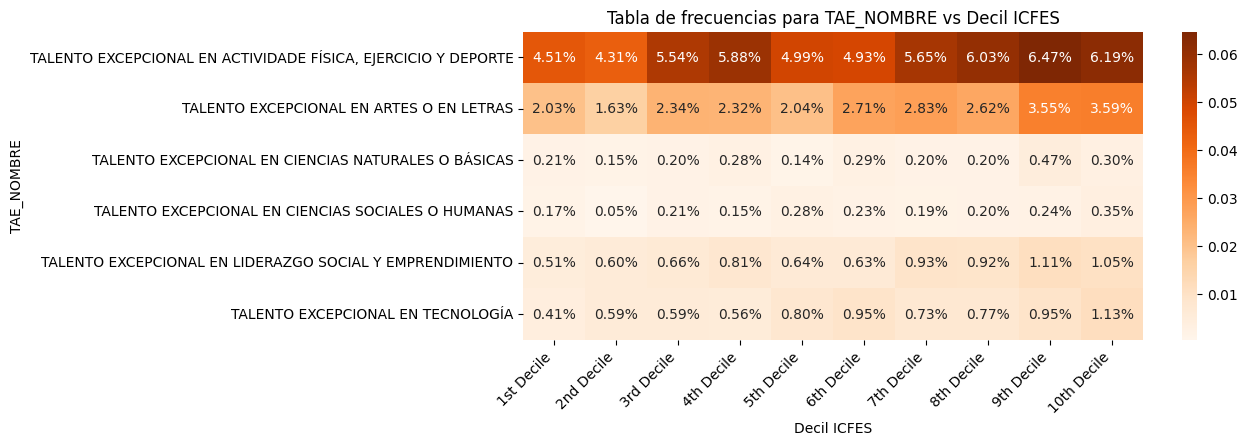

In [21]:
col = 'TAE_NOMBRE'
n = 7
y = 'Decil ICFES'
data = df[df[col] != 'NO APLICA']
base = data[col].value_counts()[:n]
suma_otros = data[col].value_counts()[n:].sum()
s = pd.concat([base,pd.Series(  {'Otros':suma_otros})]).rename('counts').reset_index().rename(columns = {'index': col})
d = data.groupby([col, y]).size().rename('Frecuencia').reset_index()
d[col] = d[col].astype(s[col].dtype)
m = d.merge(s, on = col, how= 'left')
m.loc[m['counts'].isna(), col] = 'Otros'
m = m.drop( columns = ['counts'])
m[col] = m[col].astype('str')

data = pd.pivot_table(m, values='Frecuencia',  index = [col], columns=y, aggfunc='sum')
data = data / data.sum().sum()
plt.figure(figsize=(10,4))
plt.title(f'Tabla de frecuencias para {col} vs {y}')
sns.heatmap(data, annot= True, fmt=".2%",cmap='Oranges')
plt.xticks(rotation = 45, ha = 'right')
plt.show()

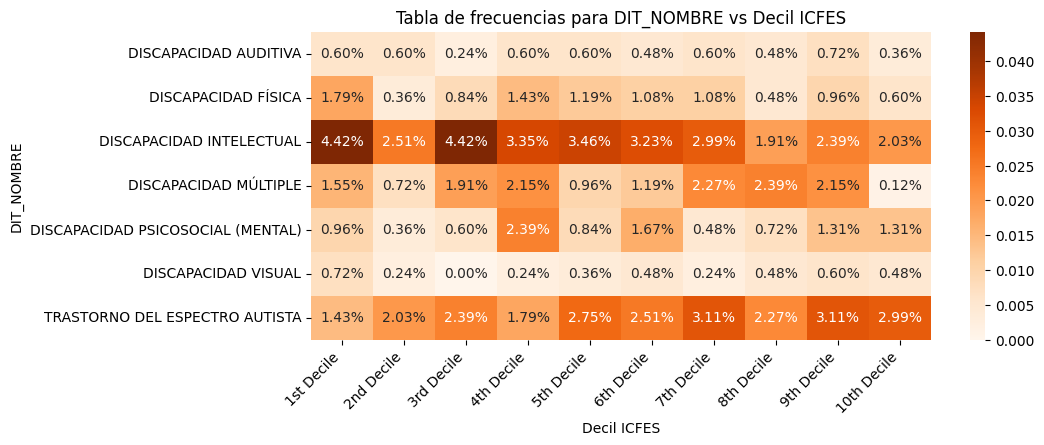

In [22]:
col = 'DIT_NOMBRE'
n = 7
y = 'Decil ICFES'
data = df[df[col] != 'NO APLICA']
base = data[col].value_counts()[:n]
suma_otros = data[col].value_counts()[n:].sum()
s = pd.concat([base,pd.Series(  {'Otros':suma_otros})]).rename('counts').reset_index().rename(columns = {'index': col})
d = data.groupby([col, y]).size().rename('Frecuencia').reset_index()
d[col] = d[col].astype(s[col].dtype)
m = d.merge(s, on = col, how= 'left')
m.loc[m['counts'].isna(), col] = 'Otros'
m = m.drop( columns = ['counts'])
m[col] = m[col].astype('str')

data = pd.pivot_table(m, values='Frecuencia',  index = [col], columns=y, aggfunc='sum')
data = data / data.sum().sum()
plt.figure(figsize=(10,4))
plt.title(f'Tabla de frecuencias para {col} vs {y}')
sns.heatmap(data, annot= True, fmt=".2%",cmap='Oranges')
plt.xticks(rotation = 45, ha = 'right')
plt.show()

In [23]:
col = 'DIT_NOMBRE'
n = 7
y = 'Decil ICFES'
data = df[df[col] != 'NO APLICA']
base = data[col].value_counts()[:n]
suma_otros = data[col].value_counts()[n:].sum()
s = pd.concat([base,pd.Series(  {'Otros':suma_otros})]).rename('counts').reset_index().rename(columns = {'index': col})
d = data.groupby([col, y]).size().rename('Frecuencia').reset_index()
d[col] = d[col].astype(s[col].dtype)
m = d.merge(s, on = col, how= 'left')
m.loc[m['counts'].isna(), col] = 'Otros'
m = m.drop( columns = ['counts'])
m[col] = m[col].astype('str')

data = pd.pivot_table(m, values='Frecuencia',  index = [col], columns=y, aggfunc='sum')
data = data / data.sum().sum()
data

Decil ICFES                        1st Decile  2nd Decile  3rd Decile  \
DIT_NOMBRE                                                              
DISCAPACIDAD AUDITIVA                0.005974    0.005974    0.002389   
DISCAPACIDAD FÍSICA                  0.017921    0.003584    0.008363   
DISCAPACIDAD INTELECTUAL             0.044205    0.025090    0.044205   
DISCAPACIDAD MÚLTIPLE                0.015532    0.007168    0.019116   
DISCAPACIDAD PSICOSOCIAL (MENTAL)    0.009558    0.003584    0.005974   
DISCAPACIDAD VISUAL                  0.007168    0.002389    0.000000   
TRASTORNO DEL ESPECTRO AUTISTA       0.014337    0.020311    0.023895   

Decil ICFES                        4th Decile  5th Decile  6th Decile  \
DIT_NOMBRE                                                              
DISCAPACIDAD AUDITIVA                0.005974    0.005974    0.004779   
DISCAPACIDAD FÍSICA                  0.014337    0.011947    0.010753   
DISCAPACIDAD INTELECTUAL             0.033453    0.034648    0.032258   
DISCAPACIDAD MÚLTIPLE                0.021505    0.009558    0.011947   
DISCAPACIDAD PSICOSOCIAL (MENTAL)    0.023895    0.008363    0.016726   
DISCAPACIDAD VISUAL                  0.002389    0.003584    0.004779   
TRASTORNO DEL ESPECTRO AUTISTA       0.017921    0.027479    0.025090   

Decil ICFES                        7th Decile  8th Decile  9th Decile  \
DIT_NOMBRE                                                              
DISCAPACIDAD AUDITIVA                0.005974    0.004779    0.007168   
DISCAPACIDAD FÍSICA                  0.010753    0.004779    0.009558   
DISCAPACIDAD INTELECTUAL             0.029869    0.019116    0.023895   
DISCAPACIDAD MÚLTIPLE                0.022700    0.023895    0.021505   
DISCAPACIDAD PSICOSOCIAL (MENTAL)    0.004779    0.007168    0.013142   
DISCAPACIDAD VISUAL                  0.002389    0.004779    0.005974   
TRASTORNO DEL ESPECTRO AUTISTA       0.031063    0.022700    0.031063   

Decil ICFES                        10th Decile  
DIT_NOMBRE                                      
DISCAPACIDAD AUDITIVA                 0.003584  
DISCAPACIDAD FÍSICA                   0.005974  
DISCAPACIDAD INTELECTUAL              0.020311  
DISCAPACIDAD MÚLTIPLE                 0.001195  
DISCAPACIDAD PSICOSOCIAL (MENTAL)     0.013142  
DISCAPACIDAD VISUAL                   0.004779  
TRASTORNO DEL ESPECTRO AUTISTA        0.029869

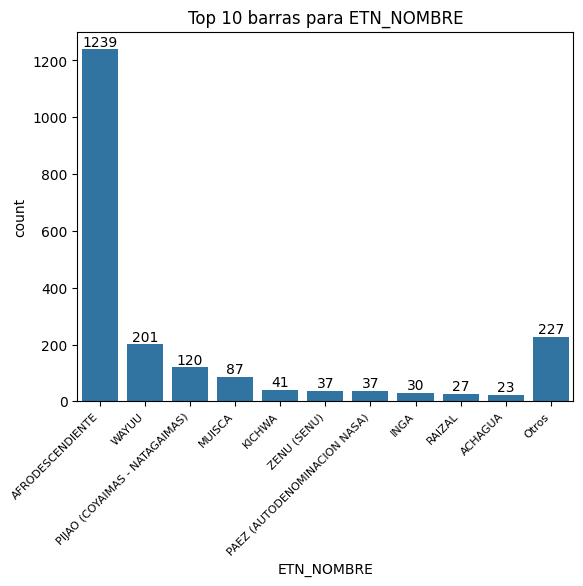

In [24]:
col = 'ETN_NOMBRE'
n = 10

test_ = df[df[col]!= 'NO APLICA'][col].value_counts().reset_index()
test_.loc[:n,'In top n?'] = 1
test_ = test_.fillna(0)
otros_ = test_[test_['In top n?'] == 0]['count'].sum()
data_ = pd.concat([test_.iloc[:n], pd.DataFrame({col: ['Otros'], 'count': [otros_], 'In top n?': [0]})], ignore_index=True)

ax = sns.barplot( data = data_, x= col, y = 'count')    
ax.bar_label(container=ax.containers[0])
plt.xticks(rotation = 45, fontsize = 8, ha= 'right')
ax.set(title = f'Top {n} barras para {col}')
plt.show()

### 2. Propuesta Metodologica

En este proyecto, proponemos una metodología que convierte variables categóricas en texto, el cual se transforma en vectores numéricos mediante embeddings utilizando un modelo de lenguaje (LLM). A continuación, aplicamos técnicas de reducción dimensional, como PCA o SVD, y ejecutamos el algoritmo de clustering con datos numéricos. Se sabe que los embeddings ayudan a que frases y textos con significados semánticos similares se representen como vectores cercanos, lo cual puede beneficiar la implementación de algoritmos como el DBSCAN donde la densidad de los datos juega un papel importante. Compararemos el desempeño de los siguientes enfoques teniendo en cuenta asignaciones justas a cupos de colegios en términos de calidad educativa: 

K-Means. 

DBSCAN. 

K-Medoids. 

LLM Parcial (aplicado a variables categóricas únicamente) + PCA + K-Means/K-Medoids/DBSCAN. 

LLM Total (aplicado a todas las variables) + PCA + K-Means/K-Medoids/DBSCAN. 

## 3.1 Proprocesamiento

In [202]:
# Ya hemos consolidado nuestra BD, la cargamos.
df = pd.read_csv('data/datos.csv')
col_categoricas = [col for col in df.columns if 'NOMBRE' in col]
col_categoricas.append('EDAD_INR')
col_categoricas.append('D_SEXO')

In [212]:
s = df[col_categoricas]

In [214]:
s.loc[s['D_SEXO'] == 'M' , 'D_SEXO'] = 'Hombre'
s.loc[s['D_SEXO'] == 'F' , 'D_SEXO'] = 'Mujer'

In [216]:
s.head(2)

GRD_NOMBRE   CIU_NOMBRE LOC_NOMBRE ZON_NOMBRE      BAR_NOMBRE  \
0  TRANSICIÓN (GRADO 0)  BOGOTÁ D.C.       USME     URBANA  BARRANQUILLITA   
1               PRIMERO  BOGOTÁ D.C.    KENNEDY     URBANA       DINTALITO   

     UPZ_NOMBRE DIT_NOMBRE TAE_NOMBRE ETN_NOMBRE PAI_NOMBRE  \
0   GRAN YOMASA  NO APLICA  NO APLICA  NO APLICA   COLOMBIA   
1  PATIO BONITO  NO APLICA  NO APLICA  NO APLICA   COLOMBIA   

              INE_NOMBRE_INTERNO  D_SEXO  EDAD_INR  
0  LIBERADO NO ACEPTA ASIGNACION  Hombre       4.0  
1              ASIGNADO ACEPTADO  Hombre       6.0

In [230]:
def compilar_categoricas(x):
    text =  f"""
                El estudiante candidato es {x['D_SEXO']} y tiene
                {int(x['EDAD_INR'])} años. Está intentando ingresar al grado   
                {x['GRD_NOMBRE']}. Proviene de la ciudad de 
                {x['CIU_NOMBRE']} de {x['PAI_NOMBRE']} y vive en una zona {x['ZON_NOMBRE']}. 
                Discapacidad: {x['DIT_NOMBRE']}.
                Talento: {x['TAE_NOMBRE']}.
                Etnia: {x['ETN_NOMBRE']}.
             """
    text = re.sub("[^\\w\\s]|\n", ' ', text)
    text = re.sub('\s+', ' ', text)
    return text

In [231]:
sentences = s.apply(lambda x: compilar_categoricas(x), axis=1).tolist()

In [234]:
sentences[:2]

[' El estudiante candidato es Hombre y tiene 4 años Está intentando ingresar al grado TRANSICIÓN GRADO 0 Proviene de la ciudad de BOGOTÁ D C de COLOMBIA y vive en una zona URBANA Discapacidad NO APLICA Talento NO APLICA Etnia NO APLICA ',
 ' El estudiante candidato es Hombre y tiene 6 años Está intentando ingresar al grado PRIMERO Proviene de la ciudad de BOGOTÁ D C de COLOMBIA y vive en una zona URBANA Discapacidad NO APLICA Talento NO APLICA Etnia NO APLICA ']

In [236]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer(r"hiiamsid/sentence_similarity_spanish_es")

In [237]:
output = model.encode(sentences=sentences, show_progress_bar= True, normalize_embeddings  = True)

Batches: 100%|███████████████████████████████████████████████████████████████████| 1919/1919 [1:05:29<00:00,  2.05s/it]


In [238]:
df_embedding = pd.DataFrame(output)
df_embedding.to_csv("data/embedding_df.csv",index = False)

In [239]:
df_embedding['des']

0         1         2         3         4         5         6    \
0      0.026229  0.009000  0.027059 -0.056850 -0.022927 -0.005288  0.039937   
1     -0.028091 -0.020587  0.045902 -0.012714 -0.010489  0.010037  0.030937   
2     -0.008352  0.004420  0.049039 -0.059168 -0.001420  0.016631 -0.006374   
3      0.019214 -0.022669  0.035043 -0.057416 -0.011307 -0.013409  0.005252   
4      0.024607  0.026025  0.021370 -0.078242 -0.015760 -0.006322  0.018827   
...         ...       ...       ...       ...       ...       ...       ...   
61394  0.018723  0.004231  0.015552 -0.117032  0.013722 -0.012682  0.035581   
61395 -0.001155 -0.003871  0.056057 -0.052066 -0.003185  0.006877  0.018311   
61396 -0.013703  0.014266  0.044137 -0.060171 -0.010701  0.020229  0.000779   
61397 -0.002849  0.022831  0.029811 -0.068205  0.025911 -0.001492 -0.028933   
61398  0.012124  0.011897  0.057748 -0.039733  0.009734  0.018622  0.044710   

            7         8         9         10        11        12        13   \
0      0.010887 -0.025599 -0.006642 -0.015209 -0.018079 -0.009995 -0.055371   
1     -0.001339 -0.029377  0.008227 -0.027030 -0.008104 -0.007749 -0.013822   
2      0.009776 -0.045339 -0.008731 -0.010076 -0.017778 -0.031713 -0.019408   
3     -0.020668 -0.010588  0.026330 -0.016175 -0.035358 -0.000670 -0.031382   
4      0.015122 -0.034345 -0.007886 -0.008333 -0.006404 -0.029360 -0.042476   
...         ...       ...       ...       ...       ...       ...       ...   
61394  0.045546 -0.017697  0.015753 -0.021327 -0.039961 -0.031382 -0.010655   
61395 -0.020471 -0.011658 -0.006480 -0.023682 -0.023231 -0.009260 -0.065638   
61396  0.005045 -0.036966 -0.006893 -0.009118 -0.024524 -0.038562 -0.011449   
61397  0.006662 -0.031891 -0.001460 -0.016386 -0.034119 -0.011468 -0.017940   
61398  0.002328 -0.031453  0.008266 -0.008327 -0.050390 -0.003523 -0.027435   

            14        15        16        17        18        19        20   \
0     -0.027653  0.031855 -0.026342 -0.080198  0.000177 -0.090744 -0.101511   
1     -0.065260  0.011139 -0.027060 -0.080637  0.008538 -0.107149 -0.063721   
2     -0.072333 -0.023401  0.012796 -0.071705 -0.001845 -0.083484 -0.042146   
3     -0.048001  0.039368 -0.000499 -0.052854 -0.024749 -0.080405 -0.047835   
4     -0.027065 -0.000772 -0.024455 -0.075710 -0.010969 -0.084489 -0.086890   
...         ...       ...       ...       ...       ...       ...       ...   
61394 -0.033737 -0.032097 -0.006559 -0.033301  0.016471 -0.059724 -0.098783   
61395 -0.072625  0.029935  0.018015 -0.075487  0.019059 -0.093748 -0.068223   
61396 -0.069460 -0.031675  0.019840 -0.058372 -0.001988 -0.083710 -0.026451   
61397 -0.026482 -0.027517 -0.003313 -0.036939  0.011960 -0.085516 -0.052968   
61398 -0.060401  0.021587 -0.009145 -0.068258  0.002069 -0.097470 -0.088937   

            21        22        23        24        25        26        27   \
0      0.024033  0.020903 -0.016262 -0.015796  0.001938  0.025073  0.044971   
1      0.012868  0.017511 -0.024803 -0.019581 -0.007762  0.015744  0.034574   
2      0.025501 -0.024240 -0.001256 -0.026187 -0.015481  0.010091  0.066890   
3      0.013447 -0.002541 -0.040877 -0.034054 -0.023110  0.014605  0.058868   
4      0.019653  0.004657  0.004142 -0.014991 -0.019610  0.022995  0.055067   
...         ...       ...       ...       ...       ...       ...       ...   
61394  0.027299 -0.012696 -0.012178 -0.012410 -0.018782  0.008027  0.062316   
61395  0.006103  0.002362 -0.031238 -0.011061  0.027049  0.022966  0.063988   
61396  0.010932 -0.035209 -0.005042 -0.024121 -0.026721  0.015543  0.065697   
61397  0.032247 -0.024527  0.006199 -0.009935 -0.030705  0.026461  0.057453   
61398  0.054555  0.004020 -0.038663 -0.009076  0.022938  0.029108  0.053093   

            28        29        30        31        32        33        34   \
0      0.028550  0.056529  0.008137  0.019152  0.029022 -0.002503  0.003875   
1      0.019075  0.053942 -0.003339 -0.006168  0.005649  0

In [25]:
## Pendiente

## Requerimientos

In [26]:
import session_info

session_info.show(html=False)


-----
matplotlib          3.9.2
numpy               1.26.4
pandas              2.2.3
seaborn             0.13.2
session_info        1.0.0
-----
IPython             8.27.0
jupyter_client      8.6.3
jupyter_core        5.7.2
jupyterlab          4.2.5
-----
Python 3.11.5 (tags/v3.11.5:cce6ba9, Aug 24 2023, 14:38:34) [MSC v.1936 64 bit (AMD64)]
Windows-10-10.0.22631-SP0
-----
Session information updated at 2024-09-21 12:54
